# SUV Purchase Predictor

In this notebook, we will train a logistic regression model to predict whether or not one should buy an SUV given their age, gender, and annual salary. The purpose of this programming exercise is to expose students to the **PyTorch** framework, as well as diving deeper into the architecture of learning algorithms.

## Introduction

Suppose you are thinking about buying an SUV, however you are not sure whether or not you should drop the money on a new car. You decide to make a classifier that learns people's decisions in the past to aid you in your own decision. You are given a dataset with the features `UserID`, `Gender`, `Age`, `EstimatedSalary`, as well as your label `Purchased`.

## Unpacking the dataset

In [1]:
import numpy as np
import pandas as pd
import torch

pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv('datasets/SUV_Purchase.csv')
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
# Converting Gender into categorical values
gender_dummies = pd.get_dummies(data['Gender'])
gender_dummies

,Female,Male
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
395,1,0
396,0,1
397,1,0
398,0,1


In [4]:
# let 0 = male, 1 = female
data['gender_num'] = gender_dummies['Female']
data

,User ID,Gender,Age,EstimatedSalary,Purchased,gender_num
0,15624510,Male,19,19000,0,0
1,15810944,Male,35,20000,0,0
2,15668575,Female,26,43000,0,1
3,15603246,Female,27,57000,0,1
4,15804002,Male,19,76000,0,0
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1
396,15706071,Male,51,23000,1,0
397,15654296,Female,50,20000,1,1
398,15755018,Male,36,33000,0,0


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Data selection
features = data[['Age', 'EstimatedSalary', 'gender_num']].to_numpy()
labels = data[['Purchased']].to_numpy()

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2)
poly= PolynomialFeatures(degree=3)

# Create Polynomial Features
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# Display shapes
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Convert into pytorch tensors 
X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).float()

(320, 20)
(320, 1)
(80, 20)
(80, 1)


In [6]:
# Number of positive and negative (females and males)
positives = np.sum(data['Purchased'].to_numpy())
negatives = int(len(data.index) - positives)

print(f'Num of positives: {positives}')
print(f'Num of negatives: {negatives}\n')

# Calculate Class Weights to balance classes
pos_weight = len(data.index)/(2 * positives)
neg_weight = len(data.index)/(2 * negatives)

print(f"positive weight: {pos_weight}")
print(f"negative weight: {neg_weight}")


def class_weights(Y_train, pos_weight, neg_weight):
    """
    calculates the weights for each and every training example
    Args:
        Y_train: training labels
        pos_weight: Weight of positive labels
        neg_weight: Weight of negative labels
    Returns:
        weights: an np.array where its shape is identical to Y_train
    """
    
    pos_mask = Y_train.astype(bool)
    neg_mask = ~Y_train.astype(bool)

    pos_mask = pos_mask.astype(np.float32) * pos_weight

    neg_mask = neg_mask.astype(np.float32) * neg_weight
    return pos_mask + neg_mask
    

weights = class_weights(Y_train, pos_weight, neg_weight)
print(weights.shape)

Num of positives: 143
Num of negatives: 257

positive weight: 1.3986013986013985
negative weight: 0.7782101167315175
(320, 1)


## Training the Logistic Regression Model

Recall from the Topic 2 Notebook, Logistic Regression differs from Linear Regression in terms of the Activation function (sigmoid) and the Cost function (BCE). Most other aspects are similar. Here we will use the `BatchNorm1d` layer to normalize the inputs.

In [7]:
from torch.nn import Module, Linear, BCELoss, BatchNorm1d
from torch.optim import SGD

class Logreg(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear  = Linear(input_dim, output_dim)
        self.bn = BatchNorm1d(input_dim)
        
    def forward(self, x):
        # Batch norm is used solely to normalize the inputs
        x = self.bn(x)
        z = self.linear(x)
        y_pred = torch.sigmoid(z)
        return y_pred
    
    def fit(self, X_train, Y_train, epochs, loss_func, opt):
        """
        Trains the model.
        Args:
            X_train, Y_train: training set and labels. Must be 
                            torch.tensor
            epochs: The number of passes over your training dataset
            loss_func: optimizing criterion
            opt: optimizing algorithm
        """
        for i in range(epochs):
            self.train()
            opt.zero_grad()
        
            Y_pred = self(X_train)
            loss = loss_func(Y_pred, Y_train)
            
            print(f"iteration {i+1}: loss: {loss.item()}")
        
            loss.backward()
            opt.step()

In [8]:
LEARNING_RATE = 0.02
EPOCHS = 50000

# Initializing a model
model = Logreg(X_train.shape[1], 1)

# Optimizing criterion and optimizing algorithm
# ignore talking about momentum and nesterov
criterion = BCELoss(weight=torch.from_numpy(weights).float())
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

if __name__ == "__main__":
    model.fit(X_train_t, Y_train_t, EPOCHS, criterion, optimizer)

iteration 1: loss: 0.7855066061019897
iteration 2: loss: 0.7525612711906433
iteration 3: loss: 0.7111790776252747
iteration 4: loss: 0.6666046977043152
iteration 5: loss: 0.6228680610656738
iteration 6: loss: 0.5824532508850098
iteration 7: loss: 0.5464895367622375
iteration 8: loss: 0.5152049660682678
iteration 9: loss: 0.488351047039032
iteration 10: loss: 0.4654792249202728
iteration 11: loss: 0.4460868239402771
iteration 12: loss: 0.42968472838401794
iteration 13: loss: 0.4158264696598053
iteration 14: loss: 0.4041185975074768
iteration 15: loss: 0.3942214846611023
iteration 16: loss: 0.3858463168144226
iteration 17: loss: 0.37874937057495117
iteration 18: loss: 0.3727259039878845
iteration 19: loss: 0.3676045835018158
iteration 20: loss: 0.36324167251586914
iteration 21: loss: 0.35951679944992065
iteration 22: loss: 0.35632866621017456
iteration 23: loss: 0.3535920977592468
iteration 24: loss: 0.35123521089553833
iteration 25: loss: 0.3491972088813782
iteration 26: loss: 0.3474270

iteration 265: loss: 0.28601592779159546
iteration 266: loss: 0.2859174609184265
iteration 267: loss: 0.2858193516731262
iteration 268: loss: 0.28572165966033936
iteration 269: loss: 0.28562501072883606
iteration 270: loss: 0.2855284810066223
iteration 271: loss: 0.285432904958725
iteration 272: loss: 0.2853375971317291
iteration 273: loss: 0.28524285554885864
iteration 274: loss: 0.2851485311985016
iteration 275: loss: 0.28505486249923706
iteration 276: loss: 0.2849618196487427
iteration 277: loss: 0.28486886620521545
iteration 278: loss: 0.28477683663368225
iteration 279: loss: 0.28468501567840576
iteration 280: loss: 0.2845936715602875
iteration 281: loss: 0.284503310918808
iteration 282: loss: 0.2844131290912628
iteration 283: loss: 0.28432339429855347
iteration 284: loss: 0.28423383831977844
iteration 285: loss: 0.28414517641067505
iteration 286: loss: 0.28405705094337463
iteration 287: loss: 0.28396880626678467
iteration 288: loss: 0.283881813287735
iteration 289: loss: 0.2837947

iteration 603: loss: 0.26934489607810974
iteration 604: loss: 0.26931872963905334
iteration 605: loss: 0.2692928910255432
iteration 606: loss: 0.26926684379577637
iteration 607: loss: 0.26924166083335876
iteration 608: loss: 0.2692156434059143
iteration 609: loss: 0.2691905200481415
iteration 610: loss: 0.2691647410392761
iteration 611: loss: 0.26913899183273315
iteration 612: loss: 0.26911407709121704
iteration 613: loss: 0.2690884470939636
iteration 614: loss: 0.26906290650367737
iteration 615: loss: 0.26903823018074036
iteration 616: loss: 0.26901280879974365
iteration 617: loss: 0.2689875066280365
iteration 618: loss: 0.26896294951438904
iteration 619: loss: 0.26893776655197144
iteration 620: loss: 0.26891258358955383
iteration 621: loss: 0.26888754963874817
iteration 622: loss: 0.2688625156879425
iteration 623: loss: 0.2688375413417816
iteration 624: loss: 0.2688134014606476
iteration 625: loss: 0.26878851652145386
iteration 626: loss: 0.26876378059387207
iteration 627: loss: 0.26

iteration 952: loss: 0.2621474862098694
iteration 953: loss: 0.2621297538280487
iteration 954: loss: 0.26211193203926086
iteration 955: loss: 0.26209431886672974
iteration 956: loss: 0.26207655668258667
iteration 957: loss: 0.26205888390541077
iteration 958: loss: 0.2620411813259125
iteration 959: loss: 0.26202359795570374
iteration 960: loss: 0.26200658082962036
iteration 961: loss: 0.26198896765708923
iteration 962: loss: 0.2619713246822357
iteration 963: loss: 0.26195377111434937
iteration 964: loss: 0.2619361877441406
iteration 965: loss: 0.2619185745716095
iteration 966: loss: 0.2619010806083679
iteration 967: loss: 0.26188355684280396
iteration 968: loss: 0.2618660032749176
iteration 969: loss: 0.2618485689163208
iteration 970: loss: 0.26183104515075684
iteration 971: loss: 0.26181358098983765
iteration 972: loss: 0.26179617643356323
iteration 973: loss: 0.26177871227264404
iteration 974: loss: 0.26176124811172485
iteration 975: loss: 0.2617438733577728
iteration 976: loss: 0.261

iteration 1291: loss: 0.25667548179626465
iteration 1292: loss: 0.25666096806526184
iteration 1293: loss: 0.25664594769477844
iteration 1294: loss: 0.256631463766098
iteration 1295: loss: 0.2566169500350952
iteration 1296: loss: 0.2566019594669342
iteration 1297: loss: 0.2565874755382538
iteration 1298: loss: 0.25657254457473755
iteration 1299: loss: 0.25655800104141235
iteration 1300: loss: 0.2565430700778961
iteration 1301: loss: 0.2565285861492157
iteration 1302: loss: 0.25651365518569946
iteration 1303: loss: 0.2564992308616638
iteration 1304: loss: 0.25648438930511475
iteration 1305: loss: 0.2564700245857239
iteration 1306: loss: 0.25645512342453003
iteration 1307: loss: 0.25644081830978394
iteration 1308: loss: 0.2564259469509125
iteration 1309: loss: 0.2564111351966858
iteration 1310: loss: 0.2563968002796173
iteration 1311: loss: 0.25638192892074585
iteration 1312: loss: 0.25636762380599976
iteration 1313: loss: 0.25635284185409546
iteration 1314: loss: 0.25633859634399414
iter

iteration 1638: loss: 0.2520361840724945
iteration 1639: loss: 0.2520241141319275
iteration 1640: loss: 0.2520124018192291
iteration 1641: loss: 0.2520003616809845
iteration 1642: loss: 0.2519882321357727
iteration 1643: loss: 0.25197622179985046
iteration 1644: loss: 0.25196465849876404
iteration 1645: loss: 0.2519526183605194
iteration 1646: loss: 0.25194060802459717
iteration 1647: loss: 0.2519286572933197
iteration 1648: loss: 0.2519169747829437
iteration 1649: loss: 0.25190502405166626
iteration 1650: loss: 0.25189319252967834
iteration 1651: loss: 0.2518812119960785
iteration 1652: loss: 0.2518692910671234
iteration 1653: loss: 0.25185731053352356
iteration 1654: loss: 0.25184571743011475
iteration 1655: loss: 0.25183379650115967
iteration 1656: loss: 0.251821905374527
iteration 1657: loss: 0.2518101632595062
iteration 1658: loss: 0.25179827213287354
iteration 1659: loss: 0.25178641080856323
iteration 1660: loss: 0.2517748475074768
iteration 1661: loss: 0.2517630457878113
iterati

iteration 1913: loss: 0.24905094504356384
iteration 1914: loss: 0.24904115498065948
iteration 1915: loss: 0.24903146922588348
iteration 1916: loss: 0.24902167916297913
iteration 1917: loss: 0.24901199340820312
iteration 1918: loss: 0.24900218844413757
iteration 1919: loss: 0.24899256229400635
iteration 1920: loss: 0.24898286163806915
iteration 1921: loss: 0.24897320568561554
iteration 1922: loss: 0.24896351993083954
iteration 1923: loss: 0.2489538937807083
iteration 1924: loss: 0.24894431233406067
iteration 1925: loss: 0.24893474578857422
iteration 1926: loss: 0.24892501533031464
iteration 1927: loss: 0.24891510605812073
iteration 1928: loss: 0.24890558421611786
iteration 1929: loss: 0.24889588356018066
iteration 1930: loss: 0.2488863468170166
iteration 1931: loss: 0.2488766461610794
iteration 1932: loss: 0.24886712431907654
iteration 1933: loss: 0.2488574981689453
iteration 1934: loss: 0.2488478720188141
iteration 1935: loss: 0.2488383948802948
iteration 1936: loss: 0.2488287985324859

iteration 2235: loss: 0.24630701541900635
iteration 2236: loss: 0.24629977345466614
iteration 2237: loss: 0.24629227817058563
iteration 2238: loss: 0.24628500640392303
iteration 2239: loss: 0.24627776443958282
iteration 2240: loss: 0.2462705373764038
iteration 2241: loss: 0.2462630718946457
iteration 2242: loss: 0.24625568091869354
iteration 2243: loss: 0.24624848365783691
iteration 2244: loss: 0.24624106287956238
iteration 2245: loss: 0.24623386561870575
iteration 2246: loss: 0.24622678756713867
iteration 2247: loss: 0.24621936678886414
iteration 2248: loss: 0.2462121993303299
iteration 2249: loss: 0.2462049424648285
iteration 2250: loss: 0.2461976259946823
iteration 2251: loss: 0.24619026482105255
iteration 2252: loss: 0.24618308246135712
iteration 2253: loss: 0.24617592990398407
iteration 2254: loss: 0.2461686134338379
iteration 2255: loss: 0.24616146087646484
iteration 2256: loss: 0.24615418910980225
iteration 2257: loss: 0.2461470663547516
iteration 2258: loss: 0.2461397647857666


iteration 2544: loss: 0.24434354901313782
iteration 2545: loss: 0.24433812499046326
iteration 2546: loss: 0.24433255195617676
iteration 2547: loss: 0.24432730674743652
iteration 2548: loss: 0.24432186782360077
iteration 2549: loss: 0.24431642889976501
iteration 2550: loss: 0.24431106448173523
iteration 2551: loss: 0.24430570006370544
iteration 2552: loss: 0.24430029094219208
iteration 2553: loss: 0.2442948818206787
iteration 2554: loss: 0.2442895472049713
iteration 2555: loss: 0.24428415298461914
iteration 2556: loss: 0.24427878856658936
iteration 2557: loss: 0.24427339434623718
iteration 2558: loss: 0.2442680299282074
iteration 2559: loss: 0.2442626655101776
iteration 2560: loss: 0.24425730109214783
iteration 2561: loss: 0.24425196647644043
iteration 2562: loss: 0.24424681067466736
iteration 2563: loss: 0.24424143135547638
iteration 2564: loss: 0.2442360818386078
iteration 2565: loss: 0.24423062801361084
iteration 2566: loss: 0.24422529339790344
iteration 2567: loss: 0.244219973683357

iteration 2853: loss: 0.24290020763874054
iteration 2854: loss: 0.24289628863334656
iteration 2855: loss: 0.24289217591285706
iteration 2856: loss: 0.24288837611675262
iteration 2857: loss: 0.2428843080997467
iteration 2858: loss: 0.2428804337978363
iteration 2859: loss: 0.24287652969360352
iteration 2860: loss: 0.2428724467754364
iteration 2861: loss: 0.24286861717700958
iteration 2862: loss: 0.24286453425884247
iteration 2863: loss: 0.24286067485809326
iteration 2864: loss: 0.24285662174224854
iteration 2865: loss: 0.24285273253917694
iteration 2866: loss: 0.2428487092256546
iteration 2867: loss: 0.2428448498249054
iteration 2868: loss: 0.2428409308195114
iteration 2869: loss: 0.2428371012210846
iteration 2870: loss: 0.24283306300640106
iteration 2871: loss: 0.24282920360565186
iteration 2872: loss: 0.2428251951932907
iteration 2873: loss: 0.2428213655948639
iteration 2874: loss: 0.24281735718250275
iteration 2875: loss: 0.24281351268291473
iteration 2876: loss: 0.2428097426891327
it

iteration 3178: loss: 0.24178794026374817
iteration 3179: loss: 0.24178501963615417
iteration 3180: loss: 0.24178233742713928
iteration 3181: loss: 0.24177929759025574
iteration 3182: loss: 0.24177642166614532
iteration 3183: loss: 0.24177336692810059
iteration 3184: loss: 0.24177046120166779
iteration 3185: loss: 0.24176745116710663
iteration 3186: loss: 0.24176457524299622
iteration 3187: loss: 0.24176189303398132
iteration 3188: loss: 0.24175886809825897
iteration 3189: loss: 0.24175599217414856
iteration 3190: loss: 0.2417529821395874
iteration 3191: loss: 0.24175012111663818
iteration 3192: loss: 0.24174723029136658
iteration 3193: loss: 0.2417442351579666
iteration 3194: loss: 0.241741344332695
iteration 3195: loss: 0.24173851311206818
iteration 3196: loss: 0.24173572659492493
iteration 3197: loss: 0.2417328655719757
iteration 3198: loss: 0.2417299747467041
iteration 3199: loss: 0.24172711372375488
iteration 3200: loss: 0.2417241334915161
iteration 3201: loss: 0.2417212724685669


iteration 3509: loss: 0.24093899130821228
iteration 3510: loss: 0.2409367561340332
iteration 3511: loss: 0.24093452095985413
iteration 3512: loss: 0.24093230068683624
iteration 3513: loss: 0.24093011021614075
iteration 3514: loss: 0.24092774093151093
iteration 3515: loss: 0.24092552065849304
iteration 3516: loss: 0.24092328548431396
iteration 3517: loss: 0.24092106521129608
iteration 3518: loss: 0.240918830037117
iteration 3519: loss: 0.2409166395664215
iteration 3520: loss: 0.24091430008411407
iteration 3521: loss: 0.2409120798110962
iteration 3522: loss: 0.2409098595380783
iteration 3523: loss: 0.24090754985809326
iteration 3524: loss: 0.24090532958507538
iteration 3525: loss: 0.2409031093120575
iteration 3526: loss: 0.240900918841362
iteration 3527: loss: 0.24089869856834412
iteration 3528: loss: 0.24089637398719788
iteration 3529: loss: 0.24089415371418
iteration 3530: loss: 0.2408919632434845
iteration 3531: loss: 0.2408897429704666
iteration 3532: loss: 0.24088755249977112
iterat

iteration 3897: loss: 0.24016407132148743
iteration 3898: loss: 0.24016232788562775
iteration 3899: loss: 0.24016058444976807
iteration 3900: loss: 0.24015870690345764
iteration 3901: loss: 0.24015697836875916
iteration 3902: loss: 0.24015524983406067
iteration 3903: loss: 0.24015335738658905
iteration 3904: loss: 0.24015161395072937
iteration 3905: loss: 0.2401498556137085
iteration 3906: loss: 0.24014802277088165
iteration 3907: loss: 0.24014627933502197
iteration 3908: loss: 0.24014440178871155
iteration 3909: loss: 0.24014267325401306
iteration 3910: loss: 0.24014094471931458
iteration 3911: loss: 0.24013908207416534
iteration 3912: loss: 0.24013736844062805
iteration 3913: loss: 0.24013559520244598
iteration 3914: loss: 0.24013376235961914
iteration 3915: loss: 0.24013201892375946
iteration 3916: loss: 0.2401302605867386
iteration 3917: loss: 0.24012836813926697
iteration 3918: loss: 0.24012665450572968
iteration 3919: loss: 0.24012494087219238
iteration 3920: loss: 0.240123182535

iteration 4215: loss: 0.23963363468647003
iteration 4216: loss: 0.23963215947151184
iteration 4217: loss: 0.23963050544261932
iteration 4218: loss: 0.23962879180908203
iteration 4219: loss: 0.239627406001091
iteration 4220: loss: 0.2396257221698761
iteration 4221: loss: 0.23962433636188507
iteration 4222: loss: 0.23962262272834778
iteration 4223: loss: 0.23962101340293884
iteration 4224: loss: 0.23961953818798065
iteration 4225: loss: 0.23961791396141052
iteration 4226: loss: 0.23961642384529114
iteration 4227: loss: 0.2396148145198822
iteration 4228: loss: 0.2396133691072464
iteration 4229: loss: 0.23961177468299866
iteration 4230: loss: 0.23961015045642853
iteration 4231: loss: 0.23960867524147034
iteration 4232: loss: 0.2396070659160614
iteration 4233: loss: 0.2396055907011032
iteration 4234: loss: 0.23960399627685547
iteration 4235: loss: 0.23960228264331818
iteration 4236: loss: 0.23960094153881073
iteration 4237: loss: 0.239599347114563
iteration 4238: loss: 0.2395976483821869
it

iteration 4543: loss: 0.23914620280265808
iteration 4544: loss: 0.23914480209350586
iteration 4545: loss: 0.23914341628551483
iteration 4546: loss: 0.23914198577404022
iteration 4547: loss: 0.23914071917533875
iteration 4548: loss: 0.23913931846618652
iteration 4549: loss: 0.23913788795471191
iteration 4550: loss: 0.2391365021467209
iteration 4551: loss: 0.23913510143756866
iteration 4552: loss: 0.23913368582725525
iteration 4553: loss: 0.23913225531578064
iteration 4554: loss: 0.2391306608915329
iteration 4555: loss: 0.23912926018238068
iteration 4556: loss: 0.23912782967090607
iteration 4557: loss: 0.23912644386291504
iteration 4558: loss: 0.23912516236305237
iteration 4559: loss: 0.23912374675273895
iteration 4560: loss: 0.23912236094474792
iteration 4561: loss: 0.23912093043327332
iteration 4562: loss: 0.23911964893341064
iteration 4563: loss: 0.23911826312541962
iteration 4564: loss: 0.239116832613945
iteration 4565: loss: 0.23911520838737488
iteration 4566: loss: 0.23911380767822

iteration 4897: loss: 0.23866531252861023
iteration 4898: loss: 0.23866383731365204
iteration 4899: loss: 0.23866276443004608
iteration 4900: loss: 0.2386612892150879
iteration 4901: loss: 0.2386600226163864
iteration 4902: loss: 0.23865871131420135
iteration 4903: loss: 0.23865744471549988
iteration 4904: loss: 0.23865601420402527
iteration 4905: loss: 0.23865476250648499
iteration 4906: loss: 0.23865342140197754
iteration 4907: loss: 0.23865218460559845
iteration 4908: loss: 0.23865072429180145
iteration 4909: loss: 0.2386496365070343
iteration 4910: loss: 0.2386482059955597
iteration 4911: loss: 0.23864693939685822
iteration 4912: loss: 0.23864562809467316
iteration 4913: loss: 0.23864436149597168
iteration 4914: loss: 0.2386428862810135
iteration 4915: loss: 0.23864178359508514
iteration 4916: loss: 0.23864033818244934
iteration 4917: loss: 0.238639235496521
iteration 4918: loss: 0.23863771557807922
iteration 4919: loss: 0.23863646388053894
iteration 4920: loss: 0.23863515257835388

iteration 5217: loss: 0.23825888335704803
iteration 5218: loss: 0.23825755715370178
iteration 5219: loss: 0.23825640976428986
iteration 5220: loss: 0.23825518786907196
iteration 5221: loss: 0.2382538765668869
iteration 5222: loss: 0.23825272917747498
iteration 5223: loss: 0.23825159668922424
iteration 5224: loss: 0.2382502257823944
iteration 5225: loss: 0.2382490634918213
iteration 5226: loss: 0.23824772238731384
iteration 5227: loss: 0.23824641108512878
iteration 5228: loss: 0.2382453978061676
iteration 5229: loss: 0.23824408650398254
iteration 5230: loss: 0.23824289441108704
iteration 5231: loss: 0.2382415533065796
iteration 5232: loss: 0.23824024200439453
iteration 5233: loss: 0.23823924362659454
iteration 5234: loss: 0.23823794722557068
iteration 5235: loss: 0.23823674023151398
iteration 5236: loss: 0.23823539912700653
iteration 5237: loss: 0.23823408782482147
iteration 5238: loss: 0.23823311924934387
iteration 5239: loss: 0.23823177814483643
iteration 5240: loss: 0.238230615854263

iteration 5498: loss: 0.23791953921318054
iteration 5499: loss: 0.237918421626091
iteration 5500: loss: 0.2379172146320343
iteration 5501: loss: 0.2379159927368164
iteration 5502: loss: 0.23791489005088806
iteration 5503: loss: 0.23791365325450897
iteration 5504: loss: 0.23791241645812988
iteration 5505: loss: 0.2379113733768463
iteration 5506: loss: 0.23791012167930603
iteration 5507: loss: 0.23790888488292694
iteration 5508: loss: 0.2379077970981598
iteration 5509: loss: 0.2379065454006195
iteration 5510: loss: 0.23790530860424042
iteration 5511: loss: 0.23790426552295685
iteration 5512: loss: 0.23790304362773895
iteration 5513: loss: 0.23790180683135986
iteration 5514: loss: 0.23790070414543152
iteration 5515: loss: 0.23789949715137482
iteration 5516: loss: 0.2378983050584793
iteration 5517: loss: 0.23789720237255096
iteration 5518: loss: 0.23789596557617188
iteration 5519: loss: 0.23789489269256592
iteration 5520: loss: 0.23789362609386444
iteration 5521: loss: 0.23789243400096893


iteration 5884: loss: 0.23747572302818298
iteration 5885: loss: 0.23747465014457703
iteration 5886: loss: 0.2374735325574875
iteration 5887: loss: 0.23747222125530243
iteration 5888: loss: 0.2374711036682129
iteration 5889: loss: 0.23747017979621887
iteration 5890: loss: 0.23746907711029053
iteration 5891: loss: 0.23746776580810547
iteration 5892: loss: 0.23746666312217712
iteration 5893: loss: 0.23746557533740997
iteration 5894: loss: 0.23746462166309357
iteration 5895: loss: 0.2374633550643921
iteration 5896: loss: 0.23746225237846375
iteration 5897: loss: 0.2374611347913742
iteration 5898: loss: 0.23746006190776825
iteration 5899: loss: 0.23745889961719513
iteration 5900: loss: 0.23745779693126678
iteration 5901: loss: 0.23745670914649963
iteration 5902: loss: 0.2374556064605713
iteration 5903: loss: 0.23745429515838623
iteration 5904: loss: 0.2374533712863922
iteration 5905: loss: 0.23745223879814148
iteration 5906: loss: 0.23745115101337433
iteration 5907: loss: 0.2374498397111892

iteration 6164: loss: 0.23716774582862854
iteration 6165: loss: 0.23716656863689423
iteration 6166: loss: 0.23716554045677185
iteration 6167: loss: 0.23716433346271515
iteration 6168: loss: 0.2371634691953659
iteration 6169: loss: 0.23716244101524353
iteration 6170: loss: 0.23716124892234802
iteration 6171: loss: 0.23716020584106445
iteration 6172: loss: 0.23715904355049133
iteration 6173: loss: 0.23715801537036896
iteration 6174: loss: 0.23715698719024658
iteration 6175: loss: 0.23715579509735107
iteration 6176: loss: 0.2371547669172287
iteration 6177: loss: 0.23715360462665558
iteration 6178: loss: 0.2371525764465332
iteration 6179: loss: 0.23715154826641083
iteration 6180: loss: 0.23715026676654816
iteration 6181: loss: 0.2371492087841034
iteration 6182: loss: 0.2371482104063034
iteration 6183: loss: 0.2371470183134079
iteration 6184: loss: 0.23714616894721985
iteration 6185: loss: 0.23714497685432434
iteration 6186: loss: 0.23714396357536316
iteration 6187: loss: 0.2371429651975631

iteration 6475: loss: 0.2368377447128296
iteration 6476: loss: 0.23683662712574005
iteration 6477: loss: 0.23683571815490723
iteration 6478: loss: 0.23683440685272217
iteration 6479: loss: 0.23683349788188934
iteration 6480: loss: 0.23683235049247742
iteration 6481: loss: 0.2368314564228058
iteration 6482: loss: 0.23683035373687744
iteration 6483: loss: 0.23682942986488342
iteration 6484: loss: 0.23682832717895508
iteration 6485: loss: 0.23682737350463867
iteration 6486: loss: 0.236826092004776
iteration 6487: loss: 0.23682518303394318
iteration 6488: loss: 0.23682408034801483
iteration 6489: loss: 0.2368231564760208
iteration 6490: loss: 0.23682203888893127
iteration 6491: loss: 0.23682110011577606
iteration 6492: loss: 0.23681998252868652
iteration 6493: loss: 0.23681895434856415
iteration 6494: loss: 0.2368178367614746
iteration 6495: loss: 0.2368168830871582
iteration 6496: loss: 0.23681576550006866
iteration 6497: loss: 0.23681466281414032
iteration 6498: loss: 0.2368137389421463


iteration 6768: loss: 0.23653721809387207
iteration 6769: loss: 0.2365361750125885
iteration 6770: loss: 0.23653516173362732
iteration 6771: loss: 0.23653411865234375
iteration 6772: loss: 0.23653307557106018
iteration 6773: loss: 0.236532062292099
iteration 6774: loss: 0.23653122782707214
iteration 6775: loss: 0.23653002083301544
iteration 6776: loss: 0.2365291565656662
iteration 6777: loss: 0.2365281581878662
iteration 6778: loss: 0.2365269660949707
iteration 6779: loss: 0.23652610182762146
iteration 6780: loss: 0.23652508854866028
iteration 6781: loss: 0.23652389645576477
iteration 6782: loss: 0.23652303218841553
iteration 6783: loss: 0.23652204871177673
iteration 6784: loss: 0.23652096092700958
iteration 6785: loss: 0.2365199774503708
iteration 6786: loss: 0.23651909828186035
iteration 6787: loss: 0.23651790618896484
iteration 6788: loss: 0.23651699721813202
iteration 6789: loss: 0.23651614785194397
iteration 6790: loss: 0.23651492595672607
iteration 6791: loss: 0.23651406168937683

iteration 7105: loss: 0.23620232939720154
iteration 7106: loss: 0.23620137572288513
iteration 7107: loss: 0.2362004518508911
iteration 7108: loss: 0.23619933426380157
iteration 7109: loss: 0.23619849979877472
iteration 7110: loss: 0.23619742691516876
iteration 7111: loss: 0.23619647324085236
iteration 7112: loss: 0.23619548976421356
iteration 7113: loss: 0.23619458079338074
iteration 7114: loss: 0.23619344830513
iteration 7115: loss: 0.23619265854358673
iteration 7116: loss: 0.2361915558576584
iteration 7117: loss: 0.23619043827056885
iteration 7118: loss: 0.23618964850902557
iteration 7119: loss: 0.23618850111961365
iteration 7120: loss: 0.23618774116039276
iteration 7121: loss: 0.23618659377098083
iteration 7122: loss: 0.2361856997013092
iteration 7123: loss: 0.2361847460269928
iteration 7124: loss: 0.23618380725383759
iteration 7125: loss: 0.23618265986442566
iteration 7126: loss: 0.23618188500404358
iteration 7127: loss: 0.23618081212043762
iteration 7128: loss: 0.23617997765541077

iteration 7406: loss: 0.23591165244579315
iteration 7407: loss: 0.23591060936450958
iteration 7408: loss: 0.23590955138206482
iteration 7409: loss: 0.2359086573123932
iteration 7410: loss: 0.23590782284736633
iteration 7411: loss: 0.23590688407421112
iteration 7412: loss: 0.23590584099292755
iteration 7413: loss: 0.2359047830104828
iteration 7414: loss: 0.2359040230512619
iteration 7415: loss: 0.23590299487113953
iteration 7416: loss: 0.23590195178985596
iteration 7417: loss: 0.23590107262134552
iteration 7418: loss: 0.23590019345283508
iteration 7419: loss: 0.23589912056922913
iteration 7420: loss: 0.2358982115983963
iteration 7421: loss: 0.23589718341827393
iteration 7422: loss: 0.2358963042497635
iteration 7423: loss: 0.23589539527893066
iteration 7424: loss: 0.23589424788951874
iteration 7425: loss: 0.2358933389186859
iteration 7426: loss: 0.23589229583740234
iteration 7427: loss: 0.2358914315700531
iteration 7428: loss: 0.23589053750038147
iteration 7429: loss: 0.2358894795179367


iteration 7716: loss: 0.23561859130859375
iteration 7717: loss: 0.23561759293079376
iteration 7718: loss: 0.23561672866344452
iteration 7719: loss: 0.23561573028564453
iteration 7720: loss: 0.2356148660182953
iteration 7721: loss: 0.2356138974428177
iteration 7722: loss: 0.2356129139661789
iteration 7723: loss: 0.23561206459999084
iteration 7724: loss: 0.23561105132102966
iteration 7725: loss: 0.23561005294322968
iteration 7726: loss: 0.23560920357704163
iteration 7727: loss: 0.23560822010040283
iteration 7728: loss: 0.23560723662376404
iteration 7729: loss: 0.2356063574552536
iteration 7730: loss: 0.235605388879776
iteration 7731: loss: 0.23560452461242676
iteration 7732: loss: 0.23560354113578796
iteration 7733: loss: 0.23560269176959991
iteration 7734: loss: 0.23560182750225067
iteration 7735: loss: 0.23560085892677307
iteration 7736: loss: 0.23559987545013428
iteration 7737: loss: 0.23559901118278503
iteration 7738: loss: 0.23559801280498505
iteration 7739: loss: 0.2355970442295074

iteration 8027: loss: 0.23532986640930176
iteration 8028: loss: 0.23532888293266296
iteration 8029: loss: 0.23532792925834656
iteration 8030: loss: 0.2353270947933197
iteration 8031: loss: 0.23532620072364807
iteration 8032: loss: 0.23532524704933167
iteration 8033: loss: 0.2353244572877884
iteration 8034: loss: 0.23532328009605408
iteration 8035: loss: 0.235322505235672
iteration 8036: loss: 0.23532156646251678
iteration 8037: loss: 0.23532059788703918
iteration 8038: loss: 0.2353198081254959
iteration 8039: loss: 0.2353188544511795
iteration 8040: loss: 0.23531779646873474
iteration 8041: loss: 0.2353169023990631
iteration 8042: loss: 0.2353159487247467
iteration 8043: loss: 0.23531515896320343
iteration 8044: loss: 0.23531422019004822
iteration 8045: loss: 0.23531341552734375
iteration 8046: loss: 0.2353122979402542
iteration 8047: loss: 0.23531131446361542
iteration 8048: loss: 0.23531052470207214
iteration 8049: loss: 0.23530957102775574
iteration 8050: loss: 0.23530876636505127
i

iteration 8323: loss: 0.23505833745002747
iteration 8324: loss: 0.23505723476409912
iteration 8325: loss: 0.23505644500255585
iteration 8326: loss: 0.2350553721189499
iteration 8327: loss: 0.23505452275276184
iteration 8328: loss: 0.23505373299121857
iteration 8329: loss: 0.23505263030529022
iteration 8330: loss: 0.23505182564258575
iteration 8331: loss: 0.2350507527589798
iteration 8332: loss: 0.2350500077009201
iteration 8333: loss: 0.23504909873008728
iteration 8334: loss: 0.23504813015460968
iteration 8335: loss: 0.23504722118377686
iteration 8336: loss: 0.23504647612571716
iteration 8337: loss: 0.23504535853862762
iteration 8338: loss: 0.2350444793701172
iteration 8339: loss: 0.2350434958934784
iteration 8340: loss: 0.23504261672496796
iteration 8341: loss: 0.23504182696342468
iteration 8342: loss: 0.23504075407981873
iteration 8343: loss: 0.23503997921943665
iteration 8344: loss: 0.2350388467311859
iteration 8345: loss: 0.23503808677196503
iteration 8346: loss: 0.2350372076034546

iteration 8631: loss: 0.23477740585803986
iteration 8632: loss: 0.23477646708488464
iteration 8633: loss: 0.2347756177186966
iteration 8634: loss: 0.23477467894554138
iteration 8635: loss: 0.2347739189863205
iteration 8636: loss: 0.2347729206085205
iteration 8637: loss: 0.23477213084697723
iteration 8638: loss: 0.23477105796337128
iteration 8639: loss: 0.23477013409137726
iteration 8640: loss: 0.23476926982402802
iteration 8641: loss: 0.234768345952034
iteration 8642: loss: 0.23476746678352356
iteration 8643: loss: 0.23476652801036835
iteration 8644: loss: 0.2347656488418579
iteration 8645: loss: 0.2347647249698639
iteration 8646: loss: 0.23476366698741913
iteration 8647: loss: 0.23476290702819824
iteration 8648: loss: 0.23476186394691467
iteration 8649: loss: 0.23476114869117737
iteration 8650: loss: 0.23476020991802216
iteration 8651: loss: 0.2347591370344162
iteration 8652: loss: 0.2347584068775177
iteration 8653: loss: 0.23475737869739532
iteration 8654: loss: 0.23475661873817444
i

iteration 9020: loss: 0.2344236820936203
iteration 9021: loss: 0.2344226837158203
iteration 9022: loss: 0.2344217747449875
iteration 9023: loss: 0.23442086577415466
iteration 9024: loss: 0.2344198226928711
iteration 9025: loss: 0.23441915214061737
iteration 9026: loss: 0.234418123960495
iteration 9027: loss: 0.23441722989082336
iteration 9028: loss: 0.23441633582115173
iteration 9029: loss: 0.23441529273986816
iteration 9030: loss: 0.23441441357135773
iteration 9031: loss: 0.23441369831562042
iteration 9032: loss: 0.23441267013549805
iteration 9033: loss: 0.2344117909669876
iteration 9034: loss: 0.23441091179847717
iteration 9035: loss: 0.2344098538160324
iteration 9036: loss: 0.23440897464752197
iteration 9037: loss: 0.23440806567668915
iteration 9038: loss: 0.2344072163105011
iteration 9039: loss: 0.23440635204315186
iteration 9040: loss: 0.2344052791595459
iteration 9041: loss: 0.23440447449684143
iteration 9042: loss: 0.23440352082252502
iteration 9043: loss: 0.23440270125865936
it

iteration 9392: loss: 0.2340838462114334
iteration 9393: loss: 0.23408281803131104
iteration 9394: loss: 0.2340819537639618
iteration 9395: loss: 0.23408105969429016
iteration 9396: loss: 0.23408007621765137
iteration 9397: loss: 0.23407921195030212
iteration 9398: loss: 0.2340783178806305
iteration 9399: loss: 0.23407742381095886
iteration 9400: loss: 0.23407645523548126
iteration 9401: loss: 0.23407559096813202
iteration 9402: loss: 0.23407471179962158
iteration 9403: loss: 0.23407351970672607
iteration 9404: loss: 0.23407264053821564
iteration 9405: loss: 0.2340717762708664
iteration 9406: loss: 0.23407086730003357
iteration 9407: loss: 0.23406989872455597
iteration 9408: loss: 0.2340690642595291
iteration 9409: loss: 0.2340681254863739
iteration 9410: loss: 0.23406729102134705
iteration 9411: loss: 0.23406629264354706
iteration 9412: loss: 0.23406541347503662
iteration 9413: loss: 0.23406454920768738
iteration 9414: loss: 0.23406365513801575
iteration 9415: loss: 0.2340626716613769

iteration 9744: loss: 0.2337593138217926
iteration 9745: loss: 0.23375847935676575
iteration 9746: loss: 0.23375749588012695
iteration 9747: loss: 0.23375646770000458
iteration 9748: loss: 0.23375558853149414
iteration 9749: loss: 0.23375478386878967
iteration 9750: loss: 0.23375387489795685
iteration 9751: loss: 0.23375269770622253
iteration 9752: loss: 0.23375186324119568
iteration 9753: loss: 0.23375098407268524
iteration 9754: loss: 0.2337501496076584
iteration 9755: loss: 0.23374906182289124
iteration 9756: loss: 0.23374812304973602
iteration 9757: loss: 0.23374727368354797
iteration 9758: loss: 0.23374640941619873
iteration 9759: loss: 0.23374533653259277
iteration 9760: loss: 0.23374450206756592
iteration 9761: loss: 0.23374363780021667
iteration 9762: loss: 0.23374250531196594
iteration 9763: loss: 0.2337416708469391
iteration 9764: loss: 0.23374083638191223
iteration 9765: loss: 0.2337399423122406
iteration 9766: loss: 0.23373889923095703
iteration 9767: loss: 0.23373803496360

iteration 10087: loss: 0.23343965411186218
iteration 10088: loss: 0.2334386557340622
iteration 10089: loss: 0.23343777656555176
iteration 10090: loss: 0.23343677818775177
iteration 10091: loss: 0.23343589901924133
iteration 10092: loss: 0.23343487083911896
iteration 10093: loss: 0.2334340363740921
iteration 10094: loss: 0.23343300819396973
iteration 10095: loss: 0.23343214392662048
iteration 10096: loss: 0.23343110084533691
iteration 10097: loss: 0.23343022167682648
iteration 10098: loss: 0.23342931270599365
iteration 10099: loss: 0.23342826962471008
iteration 10100: loss: 0.23342743515968323
iteration 10101: loss: 0.23342640697956085
iteration 10102: loss: 0.23342552781105042
iteration 10103: loss: 0.23342449963092804
iteration 10104: loss: 0.23342366516590118
iteration 10105: loss: 0.23342280089855194
iteration 10106: loss: 0.23342175781726837
iteration 10107: loss: 0.2334209382534027
iteration 10108: loss: 0.2334199696779251
iteration 10109: loss: 0.23341898620128632
iteration 10110

iteration 10490: loss: 0.23305854201316833
iteration 10491: loss: 0.23305749893188477
iteration 10492: loss: 0.2330566942691803
iteration 10493: loss: 0.23305563628673553
iteration 10494: loss: 0.23305463790893555
iteration 10495: loss: 0.2330538034439087
iteration 10496: loss: 0.23305277526378632
iteration 10497: loss: 0.23305177688598633
iteration 10498: loss: 0.23305097222328186
iteration 10499: loss: 0.23305001854896545
iteration 10500: loss: 0.2330489456653595
iteration 10501: loss: 0.23304812610149384
iteration 10502: loss: 0.23304708302021027
iteration 10503: loss: 0.2330460548400879
iteration 10504: loss: 0.23304525017738342
iteration 10505: loss: 0.23304419219493866
iteration 10506: loss: 0.23304322361946106
iteration 10507: loss: 0.2330423891544342
iteration 10508: loss: 0.23304136097431183
iteration 10509: loss: 0.23304033279418945
iteration 10510: loss: 0.23303930461406708
iteration 10511: loss: 0.2330385148525238
iteration 10512: loss: 0.23303747177124023
iteration 10513: 

iteration 10852: loss: 0.23271098732948303
iteration 10853: loss: 0.23270997405052185
iteration 10854: loss: 0.23270897567272186
iteration 10855: loss: 0.23270797729492188
iteration 10856: loss: 0.2327069491147995
iteration 10857: loss: 0.2327059805393219
iteration 10858: loss: 0.23270516097545624
iteration 10859: loss: 0.23270413279533386
iteration 10860: loss: 0.23270316421985626
iteration 10861: loss: 0.23270216584205627
iteration 10862: loss: 0.2327011376619339
iteration 10863: loss: 0.2327001392841339
iteration 10864: loss: 0.23269911110401154
iteration 10865: loss: 0.23269835114479065
iteration 10866: loss: 0.23269732296466827
iteration 10867: loss: 0.2326963245868683
iteration 10868: loss: 0.2326952964067459
iteration 10869: loss: 0.23269441723823547
iteration 10870: loss: 0.2326933890581131
iteration 10871: loss: 0.2326924055814743
iteration 10872: loss: 0.23269157111644745
iteration 10873: loss: 0.23269057273864746
iteration 10874: loss: 0.23268957436084747
iteration 10875: lo

iteration 11201: loss: 0.2323707640171051
iteration 11202: loss: 0.23236985504627228
iteration 11203: loss: 0.2323688566684723
iteration 11204: loss: 0.2323678433895111
iteration 11205: loss: 0.23236684501171112
iteration 11206: loss: 0.23236589133739471
iteration 11207: loss: 0.23236489295959473
iteration 11208: loss: 0.23236390948295593
iteration 11209: loss: 0.23236291110515594
iteration 11210: loss: 0.23236194252967834
iteration 11211: loss: 0.23236092925071716
iteration 11212: loss: 0.23235997557640076
iteration 11213: loss: 0.23235897719860077
iteration 11214: loss: 0.23235812783241272
iteration 11215: loss: 0.23235711455345154
iteration 11216: loss: 0.23235616087913513
iteration 11217: loss: 0.23235514760017395
iteration 11218: loss: 0.23235416412353516
iteration 11219: loss: 0.23235316574573517
iteration 11220: loss: 0.23235218226909637
iteration 11221: loss: 0.23235122859477997
iteration 11222: loss: 0.2323502004146576
iteration 11223: loss: 0.2323492020368576
iteration 11224:

iteration 11508: loss: 0.2320680320262909
iteration 11509: loss: 0.2320670336484909
iteration 11510: loss: 0.2320660799741745
iteration 11511: loss: 0.23206505179405212
iteration 11512: loss: 0.23206393420696259
iteration 11513: loss: 0.23206296563148499
iteration 11514: loss: 0.2320619821548462
iteration 11515: loss: 0.23206102848052979
iteration 11516: loss: 0.2320600301027298
iteration 11517: loss: 0.23205912113189697
iteration 11518: loss: 0.23205800354480743
iteration 11519: loss: 0.23205704987049103
iteration 11520: loss: 0.23205605149269104
iteration 11521: loss: 0.23205506801605225
iteration 11522: loss: 0.23205408453941345
iteration 11523: loss: 0.23205311596393585
iteration 11524: loss: 0.2320519983768463
iteration 11525: loss: 0.23205101490020752
iteration 11526: loss: 0.23205003142356873
iteration 11527: loss: 0.23204907774925232
iteration 11528: loss: 0.2320481240749359
iteration 11529: loss: 0.23204724490642548
iteration 11530: loss: 0.23204608261585236
iteration 11531: l

iteration 11810: loss: 0.23176681995391846
iteration 11811: loss: 0.23176589608192444
iteration 11812: loss: 0.2317647486925125
iteration 11813: loss: 0.23176375031471252
iteration 11814: loss: 0.2317628115415573
iteration 11815: loss: 0.23176166415214539
iteration 11816: loss: 0.23176074028015137
iteration 11817: loss: 0.23175975680351257
iteration 11818: loss: 0.23175887763500214
iteration 11819: loss: 0.2317577600479126
iteration 11820: loss: 0.2317568063735962
iteration 11821: loss: 0.23175585269927979
iteration 11822: loss: 0.23175473511219025
iteration 11823: loss: 0.23175378143787384
iteration 11824: loss: 0.23175284266471863
iteration 11825: loss: 0.2317517250776291
iteration 11826: loss: 0.23175077140331268
iteration 11827: loss: 0.23174981772899628
iteration 11828: loss: 0.23174867033958435
iteration 11829: loss: 0.23174774646759033
iteration 11830: loss: 0.23174676299095154
iteration 11831: loss: 0.2317456305027008
iteration 11832: loss: 0.23174473643302917
iteration 11833: 

iteration 12133: loss: 0.2314414083957672
iteration 12134: loss: 0.231440469622612
iteration 12135: loss: 0.2314395010471344
iteration 12136: loss: 0.23143842816352844
iteration 12137: loss: 0.23143747448921204
iteration 12138: loss: 0.2314363420009613
iteration 12139: loss: 0.2314353883266449
iteration 12140: loss: 0.23143427073955536
iteration 12141: loss: 0.23143334686756134
iteration 12142: loss: 0.2314322292804718
iteration 12143: loss: 0.23143139481544495
iteration 12144: loss: 0.23143048584461212
iteration 12145: loss: 0.2314293384552002
iteration 12146: loss: 0.23142845928668976
iteration 12147: loss: 0.23142731189727783
iteration 12148: loss: 0.2314263880252838
iteration 12149: loss: 0.23142528533935547
iteration 12150: loss: 0.23142430186271667
iteration 12151: loss: 0.23142321407794952
iteration 12152: loss: 0.23142226040363312
iteration 12153: loss: 0.23142138123512268
iteration 12154: loss: 0.23142023384571075
iteration 12155: loss: 0.23141932487487793
iteration 12156: los

iteration 12464: loss: 0.23110494017601013
iteration 12465: loss: 0.2311040163040161
iteration 12466: loss: 0.2311030626296997
iteration 12467: loss: 0.23110191524028778
iteration 12468: loss: 0.23110100626945496
iteration 12469: loss: 0.2310999631881714
iteration 12470: loss: 0.23109900951385498
iteration 12471: loss: 0.23109790682792664
iteration 12472: loss: 0.23109683394432068
iteration 12473: loss: 0.23109588027000427
iteration 12474: loss: 0.2310948371887207
iteration 12475: loss: 0.2310938835144043
iteration 12476: loss: 0.23109281063079834
iteration 12477: loss: 0.23109185695648193
iteration 12478: loss: 0.2310907542705536
iteration 12479: loss: 0.23108968138694763
iteration 12480: loss: 0.2310887575149536
iteration 12481: loss: 0.23108765482902527
iteration 12482: loss: 0.23108676075935364
iteration 12483: loss: 0.2310856580734253
iteration 12484: loss: 0.23108455538749695
iteration 12485: loss: 0.2310836762189865
iteration 12486: loss: 0.23108258843421936
iteration 12487: los

iteration 12772: loss: 0.23078946769237518
iteration 12773: loss: 0.23078837990760803
iteration 12774: loss: 0.23078754544258118
iteration 12775: loss: 0.23078647255897522
iteration 12776: loss: 0.23078536987304688
iteration 12777: loss: 0.23078422248363495
iteration 12778: loss: 0.23078331351280212
iteration 12779: loss: 0.23078227043151855
iteration 12780: loss: 0.2307811677455902
iteration 12781: loss: 0.23078028857707977
iteration 12782: loss: 0.23077921569347382
iteration 12783: loss: 0.23077814280986786
iteration 12784: loss: 0.2307770997285843
iteration 12785: loss: 0.2307761162519455
iteration 12786: loss: 0.23077502846717834
iteration 12787: loss: 0.23077397048473358
iteration 12788: loss: 0.23077306151390076
iteration 12789: loss: 0.2307720184326172
iteration 12790: loss: 0.23077091574668884
iteration 12791: loss: 0.23076987266540527
iteration 12792: loss: 0.23076896369457245
iteration 12793: loss: 0.2307678908109665
iteration 12794: loss: 0.23076677322387695
iteration 12795:

iteration 13050: loss: 0.23050296306610107
iteration 13051: loss: 0.2305019199848175
iteration 13052: loss: 0.23050084710121155
iteration 13053: loss: 0.2304997444152832
iteration 13054: loss: 0.23049867153167725
iteration 13055: loss: 0.2304977923631668
iteration 13056: loss: 0.23049673438072205
iteration 13057: loss: 0.23049569129943848
iteration 13058: loss: 0.2304946482181549
iteration 13059: loss: 0.23049350082874298
iteration 13060: loss: 0.23049244284629822
iteration 13061: loss: 0.23049156367778778
iteration 13062: loss: 0.23049049079418182
iteration 13063: loss: 0.23048946261405945
iteration 13064: loss: 0.23048833012580872
iteration 13065: loss: 0.23048730194568634
iteration 13066: loss: 0.2304864227771759
iteration 13067: loss: 0.23048539459705353
iteration 13068: loss: 0.2304842472076416
iteration 13069: loss: 0.23048317432403564
iteration 13070: loss: 0.23048214614391327
iteration 13071: loss: 0.2304811030626297
iteration 13072: loss: 0.23048022389411926
iteration 13073: l

iteration 13351: loss: 0.23019099235534668
iteration 13352: loss: 0.23018988966941833
iteration 13353: loss: 0.23018887639045715
iteration 13354: loss: 0.23018784821033478
iteration 13355: loss: 0.23018674552440643
iteration 13356: loss: 0.23018570244312286
iteration 13357: loss: 0.23018470406532288
iteration 13358: loss: 0.23018360137939453
iteration 13359: loss: 0.23018257319927216
iteration 13360: loss: 0.2301815003156662
iteration 13361: loss: 0.2301805019378662
iteration 13362: loss: 0.23017947375774384
iteration 13363: loss: 0.23017844557762146
iteration 13364: loss: 0.2301773577928543
iteration 13365: loss: 0.23017629981040955
iteration 13366: loss: 0.23017530143260956
iteration 13367: loss: 0.23017434775829315
iteration 13368: loss: 0.23017330467700958
iteration 13369: loss: 0.2301722764968872
iteration 13370: loss: 0.23017115890979767
iteration 13371: loss: 0.2301701307296753
iteration 13372: loss: 0.2301691472530365
iteration 13373: loss: 0.23016802966594696
iteration 13374: 

iteration 13684: loss: 0.2298441231250763
iteration 13685: loss: 0.2298431098461151
iteration 13686: loss: 0.22984203696250916
iteration 13687: loss: 0.22984103858470917
iteration 13688: loss: 0.2298399657011032
iteration 13689: loss: 0.22983893752098083
iteration 13690: loss: 0.22983786463737488
iteration 13691: loss: 0.2298368662595749
iteration 13692: loss: 0.22983583807945251
iteration 13693: loss: 0.22983479499816895
iteration 13694: loss: 0.229833722114563
iteration 13695: loss: 0.229832723736763
iteration 13696: loss: 0.2298317849636078
iteration 13697: loss: 0.2298305779695511
iteration 13698: loss: 0.2298295795917511
iteration 13699: loss: 0.22982847690582275
iteration 13700: loss: 0.22982752323150635
iteration 13701: loss: 0.229826420545578
iteration 13702: loss: 0.22982542216777802
iteration 13703: loss: 0.22982434928417206
iteration 13704: loss: 0.22982335090637207
iteration 13705: loss: 0.2298223078250885
iteration 13706: loss: 0.22982129454612732
iteration 13707: loss: 0.

iteration 14015: loss: 0.22949810326099396
iteration 14016: loss: 0.22949714958667755
iteration 14017: loss: 0.2294960469007492
iteration 14018: loss: 0.22949513792991638
iteration 14019: loss: 0.2294938862323761
iteration 14020: loss: 0.22949285805225372
iteration 14021: loss: 0.22949187457561493
iteration 14022: loss: 0.22949084639549255
iteration 14023: loss: 0.22948980331420898
iteration 14024: loss: 0.22948870062828064
iteration 14025: loss: 0.22948770225048065
iteration 14026: loss: 0.2294866144657135
iteration 14027: loss: 0.2294856607913971
iteration 14028: loss: 0.2294844388961792
iteration 14029: loss: 0.2294834405183792
iteration 14030: loss: 0.22948245704174042
iteration 14031: loss: 0.22948141396045685
iteration 14032: loss: 0.22948043048381805
iteration 14033: loss: 0.22947922348976135
iteration 14034: loss: 0.22947819530963898
iteration 14035: loss: 0.22947725653648376
iteration 14036: loss: 0.22947625815868378
iteration 14037: loss: 0.22947518527507782
iteration 14038: 

iteration 14361: loss: 0.22913551330566406
iteration 14362: loss: 0.2291344702243805
iteration 14363: loss: 0.22913332283496857
iteration 14364: loss: 0.22913233935832977
iteration 14365: loss: 0.2291313111782074
iteration 14366: loss: 0.22913017868995667
iteration 14367: loss: 0.22912922501564026
iteration 14368: loss: 0.2291281670331955
iteration 14369: loss: 0.22912701964378357
iteration 14370: loss: 0.2291260063648224
iteration 14371: loss: 0.2291249781847
iteration 14372: loss: 0.22912390530109406
iteration 14373: loss: 0.22912287712097168
iteration 14374: loss: 0.2291218340396881
iteration 14375: loss: 0.22912073135375977
iteration 14376: loss: 0.2291196882724762
iteration 14377: loss: 0.22911867499351501
iteration 14378: loss: 0.22911755740642548
iteration 14379: loss: 0.22911658883094788
iteration 14380: loss: 0.2291155606508255
iteration 14381: loss: 0.22911448776721954
iteration 14382: loss: 0.22911342978477478
iteration 14383: loss: 0.22911229729652405
iteration 14384: loss:

iteration 14637: loss: 0.22884567081928253
iteration 14638: loss: 0.22884459793567657
iteration 14639: loss: 0.2288435995578766
iteration 14640: loss: 0.22884254157543182
iteration 14641: loss: 0.22884145379066467
iteration 14642: loss: 0.2288404256105423
iteration 14643: loss: 0.22883930802345276
iteration 14644: loss: 0.22883832454681396
iteration 14645: loss: 0.22883732616901398
iteration 14646: loss: 0.22883617877960205
iteration 14647: loss: 0.22883522510528564
iteration 14648: loss: 0.22883407771587372
iteration 14649: loss: 0.22883307933807373
iteration 14650: loss: 0.22883197665214539
iteration 14651: loss: 0.2288309782743454
iteration 14652: loss: 0.22882983088493347
iteration 14653: loss: 0.22882883250713348
iteration 14654: loss: 0.22882790863513947
iteration 14655: loss: 0.22882676124572754
iteration 14656: loss: 0.22882571816444397
iteration 14657: loss: 0.22882458567619324
iteration 14658: loss: 0.22882358729839325
iteration 14659: loss: 0.2288224995136261
iteration 14660

iteration 15016: loss: 0.2284475862979889
iteration 15017: loss: 0.22844651341438293
iteration 15018: loss: 0.228445366024971
iteration 15019: loss: 0.2284444123506546
iteration 15020: loss: 0.22844333946704865
iteration 15021: loss: 0.22844228148460388
iteration 15022: loss: 0.22844119369983673
iteration 15023: loss: 0.22844013571739197
iteration 15024: loss: 0.2284391224384308
iteration 15025: loss: 0.22843801975250244
iteration 15026: loss: 0.22843703627586365
iteration 15027: loss: 0.22843590378761292
iteration 15028: loss: 0.2284349501132965
iteration 15029: loss: 0.22843387722969055
iteration 15030: loss: 0.22843274474143982
iteration 15031: loss: 0.2284317910671234
iteration 15032: loss: 0.22843067348003387
iteration 15033: loss: 0.2284296452999115
iteration 15034: loss: 0.22842863202095032
iteration 15035: loss: 0.22842755913734436
iteration 15036: loss: 0.22842645645141602
iteration 15037: loss: 0.22842542827129364
iteration 15038: loss: 0.22842442989349365
iteration 15039: lo

iteration 15316: loss: 0.2281324863433838
iteration 15317: loss: 0.22813138365745544
iteration 15318: loss: 0.22813042998313904
iteration 15319: loss: 0.2281293421983719
iteration 15320: loss: 0.22812826931476593
iteration 15321: loss: 0.22812728583812714
iteration 15322: loss: 0.2281261384487152
iteration 15323: loss: 0.22812509536743164
iteration 15324: loss: 0.2281239926815033
iteration 15325: loss: 0.22812309861183167
iteration 15326: loss: 0.22812199592590332
iteration 15327: loss: 0.22812096774578094
iteration 15328: loss: 0.22811999917030334
iteration 15329: loss: 0.22811885178089142
iteration 15330: loss: 0.22811779379844666
iteration 15331: loss: 0.22811679542064667
iteration 15332: loss: 0.2281157523393631
iteration 15333: loss: 0.22811464965343475
iteration 15334: loss: 0.22811360657215118
iteration 15335: loss: 0.2281126081943512
iteration 15336: loss: 0.22811155021190643
iteration 15337: loss: 0.22811046242713928
iteration 15338: loss: 0.2281094342470169
iteration 15339: l

iteration 15615: loss: 0.22781908512115479
iteration 15616: loss: 0.227818101644516
iteration 15617: loss: 0.22781701385974884
iteration 15618: loss: 0.22781594097614288
iteration 15619: loss: 0.22781482338905334
iteration 15620: loss: 0.22781388461589813
iteration 15621: loss: 0.22781284153461456
iteration 15622: loss: 0.22781173884868622
iteration 15623: loss: 0.22781066596508026
iteration 15624: loss: 0.2278095781803131
iteration 15625: loss: 0.22780855000019073
iteration 15626: loss: 0.22780756652355194
iteration 15627: loss: 0.22780649363994598
iteration 15628: loss: 0.22780545055866241
iteration 15629: loss: 0.22780437767505646
iteration 15630: loss: 0.22780334949493408
iteration 15631: loss: 0.2278023064136505
iteration 15632: loss: 0.2278013527393341
iteration 15633: loss: 0.22780022025108337
iteration 15634: loss: 0.22779913246631622
iteration 15635: loss: 0.22779813408851624
iteration 15636: loss: 0.22779706120491028
iteration 15637: loss: 0.22779607772827148
iteration 15638:

iteration 15967: loss: 0.22745105624198914
iteration 15968: loss: 0.22745001316070557
iteration 15969: loss: 0.22744901478290558
iteration 15970: loss: 0.22744794189929962
iteration 15971: loss: 0.22744688391685486
iteration 15972: loss: 0.22744588553905487
iteration 15973: loss: 0.2274448424577713
iteration 15974: loss: 0.22744378447532654
iteration 15975: loss: 0.22744286060333252
iteration 15976: loss: 0.22744174301624298
iteration 15977: loss: 0.22744068503379822
iteration 15978: loss: 0.22743968665599823
iteration 15979: loss: 0.22743865847587585
iteration 15980: loss: 0.2274375706911087
iteration 15981: loss: 0.22743654251098633
iteration 15982: loss: 0.22743549942970276
iteration 15983: loss: 0.22743448615074158
iteration 15984: loss: 0.22743336856365204
iteration 15985: loss: 0.22743234038352966
iteration 15986: loss: 0.2274312525987625
iteration 15987: loss: 0.2274303138256073
iteration 15988: loss: 0.22742930054664612
iteration 15989: loss: 0.22742824256420135
iteration 15990

iteration 16296: loss: 0.22710879147052765
iteration 16297: loss: 0.22710780799388885
iteration 16298: loss: 0.2271067202091217
iteration 16299: loss: 0.22710569202899933
iteration 16300: loss: 0.22710469365119934
iteration 16301: loss: 0.22710354626178741
iteration 16302: loss: 0.22710254788398743
iteration 16303: loss: 0.22710147500038147
iteration 16304: loss: 0.2271004617214203
iteration 16305: loss: 0.22709938883781433
iteration 16306: loss: 0.22709842026233673
iteration 16307: loss: 0.2270973026752472
iteration 16308: loss: 0.227096289396286
iteration 16309: loss: 0.2270953208208084
iteration 16310: loss: 0.22709424793720245
iteration 16311: loss: 0.2270931899547577
iteration 16312: loss: 0.22709223628044128
iteration 16313: loss: 0.2270912230014801
iteration 16314: loss: 0.22709020972251892
iteration 16315: loss: 0.22708912193775177
iteration 16316: loss: 0.22708801925182343
iteration 16317: loss: 0.22708694636821747
iteration 16318: loss: 0.2270859181880951
iteration 16319: los

iteration 16628: loss: 0.22676527500152588
iteration 16629: loss: 0.2267642468214035
iteration 16630: loss: 0.22676324844360352
iteration 16631: loss: 0.22676225006580353
iteration 16632: loss: 0.22676122188568115
iteration 16633: loss: 0.2267601191997528
iteration 16634: loss: 0.22675910592079163
iteration 16635: loss: 0.22675809264183044
iteration 16636: loss: 0.22675707936286926
iteration 16637: loss: 0.2267560511827469
iteration 16638: loss: 0.2267550230026245
iteration 16639: loss: 0.22675399482250214
iteration 16640: loss: 0.2267528474330902
iteration 16641: loss: 0.2267518937587738
iteration 16642: loss: 0.22675088047981262
iteration 16643: loss: 0.22674985229969025
iteration 16644: loss: 0.22674879431724548
iteration 16645: loss: 0.22674784064292908
iteration 16646: loss: 0.22674670815467834
iteration 16647: loss: 0.22674565017223358
iteration 16648: loss: 0.2267446517944336
iteration 16649: loss: 0.2267436534166336
iteration 16650: loss: 0.22674265503883362
iteration 16651: lo

iteration 16945: loss: 0.2264397144317627
iteration 16946: loss: 0.22643867135047913
iteration 16947: loss: 0.22643768787384033
iteration 16948: loss: 0.2264365702867508
iteration 16949: loss: 0.22643551230430603
iteration 16950: loss: 0.22643455862998962
iteration 16951: loss: 0.22643356025218964
iteration 16952: loss: 0.22643251717090607
iteration 16953: loss: 0.2264314591884613
iteration 16954: loss: 0.2264304906129837
iteration 16955: loss: 0.2264295071363449
iteration 16956: loss: 0.22642838954925537
iteration 16957: loss: 0.22642740607261658
iteration 16958: loss: 0.2264264076948166
iteration 16959: loss: 0.22642526030540466
iteration 16960: loss: 0.22642426192760468
iteration 16961: loss: 0.22642329335212708
iteration 16962: loss: 0.22642222046852112
iteration 16963: loss: 0.2264212667942047
iteration 16964: loss: 0.22642028331756592
iteration 16965: loss: 0.22641924023628235
iteration 16966: loss: 0.22641825675964355
iteration 16967: loss: 0.22641721367835999
iteration 16968: l

iteration 17262: loss: 0.22611673176288605
iteration 17263: loss: 0.22611574828624725
iteration 17264: loss: 0.22611479461193085
iteration 17265: loss: 0.2261137068271637
iteration 17266: loss: 0.2261127233505249
iteration 17267: loss: 0.22611172497272491
iteration 17268: loss: 0.22611065208911896
iteration 17269: loss: 0.22610969841480255
iteration 17270: loss: 0.2261086404323578
iteration 17271: loss: 0.2261076420545578
iteration 17272: loss: 0.22610659897327423
iteration 17273: loss: 0.22610564529895782
iteration 17274: loss: 0.22610458731651306
iteration 17275: loss: 0.22610358893871307
iteration 17276: loss: 0.22610263526439667
iteration 17277: loss: 0.2261015921831131
iteration 17278: loss: 0.22610065340995789
iteration 17279: loss: 0.22609956562519073
iteration 17280: loss: 0.22609856724739075
iteration 17281: loss: 0.22609750926494598
iteration 17282: loss: 0.22609658539295197
iteration 17283: loss: 0.22609546780586243
iteration 17284: loss: 0.22609452903270721
iteration 17285:

iteration 17571: loss: 0.22580508887767792
iteration 17572: loss: 0.2258041352033615
iteration 17573: loss: 0.22580309212207794
iteration 17574: loss: 0.22580206394195557
iteration 17575: loss: 0.22580111026763916
iteration 17576: loss: 0.22580011188983917
iteration 17577: loss: 0.22579903900623322
iteration 17578: loss: 0.22579804062843323
iteration 17579: loss: 0.22579710185527802
iteration 17580: loss: 0.22579610347747803
iteration 17581: loss: 0.22579507529735565
iteration 17582: loss: 0.2257940024137497
iteration 17583: loss: 0.2257930487394333
iteration 17584: loss: 0.2257920205593109
iteration 17585: loss: 0.22579112648963928
iteration 17586: loss: 0.22578999400138855
iteration 17587: loss: 0.22578902542591095
iteration 17588: loss: 0.22578799724578857
iteration 17589: loss: 0.22578701376914978
iteration 17590: loss: 0.2257859706878662
iteration 17591: loss: 0.22578497231006622
iteration 17592: loss: 0.225784033536911
iteration 17593: loss: 0.2257830649614334
iteration 17594: lo

iteration 17870: loss: 0.2255067378282547
iteration 17871: loss: 0.22550582885742188
iteration 17872: loss: 0.22550475597381592
iteration 17873: loss: 0.22550377249717712
iteration 17874: loss: 0.22550275921821594
iteration 17875: loss: 0.22550182044506073
iteration 17876: loss: 0.22550079226493835
iteration 17877: loss: 0.22549977898597717
iteration 17878: loss: 0.22549882531166077
iteration 17879: loss: 0.2254977971315384
iteration 17880: loss: 0.22549685835838318
iteration 17881: loss: 0.2254958599805832
iteration 17882: loss: 0.2254948914051056
iteration 17883: loss: 0.2254938781261444
iteration 17884: loss: 0.2254929095506668
iteration 17885: loss: 0.22549185156822205
iteration 17886: loss: 0.22549080848693848
iteration 17887: loss: 0.22548989951610565
iteration 17888: loss: 0.22548885643482208
iteration 17889: loss: 0.22548790276050568
iteration 17890: loss: 0.22548691928386688
iteration 17891: loss: 0.22548599541187286
iteration 17892: loss: 0.2254849225282669
iteration 17893: l

iteration 18175: loss: 0.22520604729652405
iteration 18176: loss: 0.2252051830291748
iteration 18177: loss: 0.22520413994789124
iteration 18178: loss: 0.22520315647125244
iteration 18179: loss: 0.22520223259925842
iteration 18180: loss: 0.22520121932029724
iteration 18181: loss: 0.22520020604133606
iteration 18182: loss: 0.22519925236701965
iteration 18183: loss: 0.22519823908805847
iteration 18184: loss: 0.22519724071025848
iteration 18185: loss: 0.22519631683826447
iteration 18186: loss: 0.22519536316394806
iteration 18187: loss: 0.22519426047801971
iteration 18188: loss: 0.2251933515071869
iteration 18189: loss: 0.22519239783287048
iteration 18190: loss: 0.22519150376319885
iteration 18191: loss: 0.22519049048423767
iteration 18192: loss: 0.2251894474029541
iteration 18193: loss: 0.22518853843212128
iteration 18194: loss: 0.2251874953508377
iteration 18195: loss: 0.2251865565776825
iteration 18196: loss: 0.2251855880022049
iteration 18197: loss: 0.22518455982208252
iteration 18198: 

iteration 18489: loss: 0.22490087151527405
iteration 18490: loss: 0.22489997744560242
iteration 18491: loss: 0.2248990535736084
iteration 18492: loss: 0.2248980551958084
iteration 18493: loss: 0.22489705681800842
iteration 18494: loss: 0.2248961180448532
iteration 18495: loss: 0.22489511966705322
iteration 18496: loss: 0.22489416599273682
iteration 18497: loss: 0.22489318251609802
iteration 18498: loss: 0.224892258644104
iteration 18499: loss: 0.22489123046398163
iteration 18500: loss: 0.22489023208618164
iteration 18501: loss: 0.22488930821418762
iteration 18502: loss: 0.22488835453987122
iteration 18503: loss: 0.22488737106323242
iteration 18504: loss: 0.22488649189472198
iteration 18505: loss: 0.224885493516922
iteration 18506: loss: 0.2248845100402832
iteration 18507: loss: 0.2248835563659668
iteration 18508: loss: 0.22488263249397278
iteration 18509: loss: 0.2248816192150116
iteration 18510: loss: 0.22488072514533997
iteration 18511: loss: 0.2248796969652176
iteration 18512: loss:

iteration 18784: loss: 0.22461852431297302
iteration 18785: loss: 0.22461757063865662
iteration 18786: loss: 0.22461660206317902
iteration 18787: loss: 0.2246156483888626
iteration 18788: loss: 0.22461473941802979
iteration 18789: loss: 0.224613755941391
iteration 18790: loss: 0.22461283206939697
iteration 18791: loss: 0.22461187839508057
iteration 18792: loss: 0.22461089491844177
iteration 18793: loss: 0.22461001574993134
iteration 18794: loss: 0.22460904717445374
iteration 18795: loss: 0.22460810840129852
iteration 18796: loss: 0.22460713982582092
iteration 18797: loss: 0.22460615634918213
iteration 18798: loss: 0.2246052473783493
iteration 18799: loss: 0.22460432350635529
iteration 18800: loss: 0.2246033400297165
iteration 18801: loss: 0.2246023416519165
iteration 18802: loss: 0.22460143268108368
iteration 18803: loss: 0.22460046410560608
iteration 18804: loss: 0.22459952533245087
iteration 18805: loss: 0.22459855675697327
iteration 18806: loss: 0.22459769248962402
iteration 18807: 

iteration 19096: loss: 0.2243247777223587
iteration 19097: loss: 0.22432394325733185
iteration 19098: loss: 0.22432298958301544
iteration 19099: loss: 0.22432203590869904
iteration 19100: loss: 0.22432105243206024
iteration 19101: loss: 0.22432012856006622
iteration 19102: loss: 0.22431913018226624
iteration 19103: loss: 0.22431831061840057
iteration 19104: loss: 0.22431735694408417
iteration 19105: loss: 0.22431643307209015
iteration 19106: loss: 0.22431547939777374
iteration 19107: loss: 0.22431449592113495
iteration 19108: loss: 0.22431358695030212
iteration 19109: loss: 0.22431263327598572
iteration 19110: loss: 0.22431175410747528
iteration 19111: loss: 0.22431084513664246
iteration 19112: loss: 0.22430992126464844
iteration 19113: loss: 0.22430893778800964
iteration 19114: loss: 0.22430801391601562
iteration 19115: loss: 0.22430706024169922
iteration 19116: loss: 0.22430618107318878
iteration 19117: loss: 0.22430524230003357
iteration 19118: loss: 0.22430434823036194
iteration 19

iteration 19433: loss: 0.22401371598243713
iteration 19434: loss: 0.2240128517150879
iteration 19435: loss: 0.22401192784309387
iteration 19436: loss: 0.22401101887226105
iteration 19437: loss: 0.22401003539562225
iteration 19438: loss: 0.22400912642478943
iteration 19439: loss: 0.2240082025527954
iteration 19440: loss: 0.22400732338428497
iteration 19441: loss: 0.22400644421577454
iteration 19442: loss: 0.2240055352449417
iteration 19443: loss: 0.2240045964717865
iteration 19444: loss: 0.22400370240211487
iteration 19445: loss: 0.22400271892547607
iteration 19446: loss: 0.22400183975696564
iteration 19447: loss: 0.2240009605884552
iteration 19448: loss: 0.2240000218153
iteration 19449: loss: 0.22399909794330597
iteration 19450: loss: 0.22399814426898956
iteration 19451: loss: 0.22399726510047913
iteration 19452: loss: 0.2239963561296463
iteration 19453: loss: 0.2239954173564911
iteration 19454: loss: 0.22399446368217468
iteration 19455: loss: 0.22399358451366425
iteration 19456: loss:

iteration 19756: loss: 0.22372189164161682
iteration 19757: loss: 0.2237209975719452
iteration 19758: loss: 0.22372011840343475
iteration 19759: loss: 0.22371920943260193
iteration 19760: loss: 0.2237183302640915
iteration 19761: loss: 0.22371748089790344
iteration 19762: loss: 0.2237165868282318
iteration 19763: loss: 0.2237156629562378
iteration 19764: loss: 0.22371478378772736
iteration 19765: loss: 0.22371380031108856
iteration 19766: loss: 0.22371292114257812
iteration 19767: loss: 0.22371208667755127
iteration 19768: loss: 0.22371116280555725
iteration 19769: loss: 0.22371020913124084
iteration 19770: loss: 0.2237093448638916
iteration 19771: loss: 0.22370846569538116
iteration 19772: loss: 0.2237076461315155
iteration 19773: loss: 0.22370676696300507
iteration 19774: loss: 0.22370581328868866
iteration 19775: loss: 0.22370493412017822
iteration 19776: loss: 0.22370409965515137
iteration 19777: loss: 0.22370311617851257
iteration 19778: loss: 0.22370223701000214
iteration 19779: 

iteration 20086: loss: 0.2234305888414383
iteration 20087: loss: 0.22342976927757263
iteration 20088: loss: 0.22342881560325623
iteration 20089: loss: 0.22342801094055176
iteration 20090: loss: 0.22342713177204132
iteration 20091: loss: 0.22342626750469208
iteration 20092: loss: 0.22342535853385925
iteration 20093: loss: 0.2234245240688324
iteration 20094: loss: 0.22342364490032196
iteration 20095: loss: 0.22342272102832794
iteration 20096: loss: 0.2234218567609787
iteration 20097: loss: 0.22342097759246826
iteration 20098: loss: 0.2234201431274414
iteration 20099: loss: 0.22341927886009216
iteration 20100: loss: 0.22341838479042053
iteration 20101: loss: 0.22341755032539368
iteration 20102: loss: 0.22341661155223846
iteration 20103: loss: 0.2234157770872116
iteration 20104: loss: 0.22341492772102356
iteration 20105: loss: 0.22341403365135193
iteration 20106: loss: 0.22341318428516388
iteration 20107: loss: 0.22341227531433105
iteration 20108: loss: 0.2234114110469818
iteration 20109: 

iteration 20415: loss: 0.2231474220752716
iteration 20416: loss: 0.22314655780792236
iteration 20417: loss: 0.22314564883708954
iteration 20418: loss: 0.22314481437206268
iteration 20419: loss: 0.22314396500587463
iteration 20420: loss: 0.22314317524433136
iteration 20421: loss: 0.22314229607582092
iteration 20422: loss: 0.22314147651195526
iteration 20423: loss: 0.2231406271457672
iteration 20424: loss: 0.22313973307609558
iteration 20425: loss: 0.22313889861106873
iteration 20426: loss: 0.22313804924488068
iteration 20427: loss: 0.22313718497753143
iteration 20428: loss: 0.22313639521598816
iteration 20429: loss: 0.22313551604747772
iteration 20430: loss: 0.22313471138477325
iteration 20431: loss: 0.22313383221626282
iteration 20432: loss: 0.22313292324543
iteration 20433: loss: 0.22313213348388672
iteration 20434: loss: 0.2231312245130539
iteration 20435: loss: 0.22313043475151062
iteration 20436: loss: 0.22312958538532257
iteration 20437: loss: 0.22312870621681213
iteration 20438: 

iteration 20715: loss: 0.22289571166038513
iteration 20716: loss: 0.2228948324918747
iteration 20717: loss: 0.22289402782917023
iteration 20718: loss: 0.22289323806762695
iteration 20719: loss: 0.22289244830608368
iteration 20720: loss: 0.22289152443408966
iteration 20721: loss: 0.222890704870224
iteration 20722: loss: 0.22288993000984192
iteration 20723: loss: 0.22288914024829865
iteration 20724: loss: 0.2228882759809494
iteration 20725: loss: 0.22288742661476135
iteration 20726: loss: 0.2228866070508957
iteration 20727: loss: 0.22288575768470764
iteration 20728: loss: 0.22288493812084198
iteration 20729: loss: 0.22288410365581512
iteration 20730: loss: 0.2228832244873047
iteration 20731: loss: 0.2228824645280838
iteration 20732: loss: 0.22288170456886292
iteration 20733: loss: 0.22288084030151367
iteration 20734: loss: 0.22287997603416443
iteration 20735: loss: 0.22287920117378235
iteration 20736: loss: 0.22287830710411072
iteration 20737: loss: 0.22287745773792267
iteration 20738: l

iteration 21048: loss: 0.22262385487556458
iteration 21049: loss: 0.2226230800151825
iteration 21050: loss: 0.22262230515480042
iteration 21051: loss: 0.22262144088745117
iteration 21052: loss: 0.22262068092823029
iteration 21053: loss: 0.222619891166687
iteration 21054: loss: 0.22261905670166016
iteration 21055: loss: 0.2226182222366333
iteration 21056: loss: 0.22261746227741241
iteration 21057: loss: 0.22261664271354675
iteration 21058: loss: 0.2226158082485199
iteration 21059: loss: 0.22261497378349304
iteration 21060: loss: 0.22261421382427216
iteration 21061: loss: 0.2226133793592453
iteration 21062: loss: 0.22261261940002441
iteration 21063: loss: 0.22261182963848114
iteration 21064: loss: 0.22261103987693787
iteration 21065: loss: 0.222610205411911
iteration 21066: loss: 0.22260940074920654
iteration 21067: loss: 0.22260859608650208
iteration 21068: loss: 0.2226078063249588
iteration 21069: loss: 0.22260701656341553
iteration 21070: loss: 0.22260625660419464
iteration 21071: los

iteration 21340: loss: 0.2223922312259674
iteration 21341: loss: 0.22239144146442413
iteration 21342: loss: 0.22239069640636444
iteration 21343: loss: 0.22238990664482117
iteration 21344: loss: 0.2223891317844391
iteration 21345: loss: 0.222388356924057
iteration 21346: loss: 0.22238759696483612
iteration 21347: loss: 0.22238680720329285
iteration 21348: loss: 0.2223859280347824
iteration 21349: loss: 0.2223852127790451
iteration 21350: loss: 0.22238445281982422
iteration 21351: loss: 0.22238364815711975
iteration 21352: loss: 0.22238287329673767
iteration 21353: loss: 0.2223820984363556
iteration 21354: loss: 0.2223813533782959
iteration 21355: loss: 0.22238054871559143
iteration 21356: loss: 0.2223796844482422
iteration 21357: loss: 0.22237887978553772
iteration 21358: loss: 0.22237813472747803
iteration 21359: loss: 0.22237741947174072
iteration 21360: loss: 0.22237658500671387
iteration 21361: loss: 0.22237582504749298
iteration 21362: loss: 0.2223750650882721
iteration 21363: loss

iteration 21656: loss: 0.2221488207578659
iteration 21657: loss: 0.22214803099632263
iteration 21658: loss: 0.2221473753452301
iteration 21659: loss: 0.22214651107788086
iteration 21660: loss: 0.22214579582214355
iteration 21661: loss: 0.22214503586292267
iteration 21662: loss: 0.2221442461013794
iteration 21663: loss: 0.2221434861421585
iteration 21664: loss: 0.22214269638061523
iteration 21665: loss: 0.22214190661907196
iteration 21666: loss: 0.22214126586914062
iteration 21667: loss: 0.22214047610759735
iteration 21668: loss: 0.22213968634605408
iteration 21669: loss: 0.22213897109031677
iteration 21670: loss: 0.2221381664276123
iteration 21671: loss: 0.22213740646839142
iteration 21672: loss: 0.22213666141033173
iteration 21673: loss: 0.22213593125343323
iteration 21674: loss: 0.22213515639305115
iteration 21675: loss: 0.22213438153266907
iteration 21676: loss: 0.22213363647460938
iteration 21677: loss: 0.22213292121887207
iteration 21678: loss: 0.22213216125965118
iteration 21679:

iteration 21970: loss: 0.22191448509693146
iteration 21971: loss: 0.22191376984119415
iteration 21972: loss: 0.22191300988197327
iteration 21973: loss: 0.22191229462623596
iteration 21974: loss: 0.22191151976585388
iteration 21975: loss: 0.22191080451011658
iteration 21976: loss: 0.22191008925437927
iteration 21977: loss: 0.22190937399864197
iteration 21978: loss: 0.22190861403942108
iteration 21979: loss: 0.2219078540802002
iteration 21980: loss: 0.22190718352794647
iteration 21981: loss: 0.2219063937664032
iteration 21982: loss: 0.22190570831298828
iteration 21983: loss: 0.2219049483537674
iteration 21984: loss: 0.2219042330980301
iteration 21985: loss: 0.2219034880399704
iteration 21986: loss: 0.22190280258655548
iteration 21987: loss: 0.2219020426273346
iteration 21988: loss: 0.2219012975692749
iteration 21989: loss: 0.22190061211585999
iteration 21990: loss: 0.2218998223543167
iteration 21991: loss: 0.2218991219997406
iteration 21992: loss: 0.22189836204051971
iteration 21993: los

iteration 22289: loss: 0.22168433666229248
iteration 22290: loss: 0.2216835767030716
iteration 22291: loss: 0.22168290615081787
iteration 22292: loss: 0.22168214619159698
iteration 22293: loss: 0.22168143093585968
iteration 22294: loss: 0.22168073058128357
iteration 22295: loss: 0.22168007493019104
iteration 22296: loss: 0.22167930006980896
iteration 22297: loss: 0.22167861461639404
iteration 22298: loss: 0.22167794406414032
iteration 22299: loss: 0.22167715430259705
iteration 22300: loss: 0.22167649865150452
iteration 22301: loss: 0.2216757833957672
iteration 22302: loss: 0.2216751128435135
iteration 22303: loss: 0.2216743677854538
iteration 22304: loss: 0.22167368233203888
iteration 22305: loss: 0.2216729372739792
iteration 22306: loss: 0.22167225182056427
iteration 22307: loss: 0.22167150676250458
iteration 22308: loss: 0.22167082130908966
iteration 22309: loss: 0.22167010605335236
iteration 22310: loss: 0.22166943550109863
iteration 22311: loss: 0.22166872024536133
iteration 22312:

iteration 22629: loss: 0.2214476764202118
iteration 22630: loss: 0.22144702076911926
iteration 22631: loss: 0.22144632041454315
iteration 22632: loss: 0.2214457094669342
iteration 22633: loss: 0.22144491970539093
iteration 22634: loss: 0.2214442789554596
iteration 22635: loss: 0.2214435636997223
iteration 22636: loss: 0.22144290804862976
iteration 22637: loss: 0.22144226729869843
iteration 22638: loss: 0.22144150733947754
iteration 22639: loss: 0.2214408665895462
iteration 22640: loss: 0.22144010663032532
iteration 22641: loss: 0.2214394509792328
iteration 22642: loss: 0.22143881022930145
iteration 22643: loss: 0.22143813967704773
iteration 22644: loss: 0.2214374542236328
iteration 22645: loss: 0.2214367687702179
iteration 22646: loss: 0.22143599390983582
iteration 22647: loss: 0.22143538296222687
iteration 22648: loss: 0.22143468260765076
iteration 22649: loss: 0.22143404185771942
iteration 22650: loss: 0.2214333564043045
iteration 22651: loss: 0.22143271565437317
iteration 22652: los

iteration 22952: loss: 0.22123125195503235
iteration 22953: loss: 0.2212306559085846
iteration 22954: loss: 0.22122998535633087
iteration 22955: loss: 0.22122931480407715
iteration 22956: loss: 0.221228688955307
iteration 22957: loss: 0.2212279587984085
iteration 22958: loss: 0.22122736275196075
iteration 22959: loss: 0.22122672200202942
iteration 22960: loss: 0.22122600674629211
iteration 22961: loss: 0.22122538089752197
iteration 22962: loss: 0.22122474014759064
iteration 22963: loss: 0.2212240993976593
iteration 22964: loss: 0.22122347354888916
iteration 22965: loss: 0.22122278809547424
iteration 22966: loss: 0.22122208774089813
iteration 22967: loss: 0.2212214469909668
iteration 22968: loss: 0.22122082114219666
iteration 22969: loss: 0.22122009098529816
iteration 22970: loss: 0.2212194949388504
iteration 22971: loss: 0.2212187796831131
iteration 22972: loss: 0.22121815383434296
iteration 22973: loss: 0.22121748328208923
iteration 22974: loss: 0.22121687233448029
iteration 22975: lo

iteration 23272: loss: 0.22102496027946472
iteration 23273: loss: 0.2210243046283722
iteration 23274: loss: 0.22102370858192444
iteration 23275: loss: 0.22102303802967072
iteration 23276: loss: 0.22102241218090057
iteration 23277: loss: 0.22102181613445282
iteration 23278: loss: 0.2210211306810379
iteration 23279: loss: 0.22102057933807373
iteration 23280: loss: 0.2210199385881424
iteration 23281: loss: 0.22101931273937225
iteration 23282: loss: 0.22101859748363495
iteration 23283: loss: 0.22101803123950958
iteration 23284: loss: 0.22101740539073944
iteration 23285: loss: 0.2210167646408081
iteration 23286: loss: 0.22101609408855438
iteration 23287: loss: 0.22101549804210663
iteration 23288: loss: 0.2210148572921753
iteration 23289: loss: 0.22101426124572754
iteration 23290: loss: 0.22101359069347382
iteration 23291: loss: 0.22101297974586487
iteration 23292: loss: 0.22101238369941711
iteration 23293: loss: 0.22101172804832458
iteration 23294: loss: 0.22101107239723206
iteration 23295:

iteration 23581: loss: 0.22083325684070587
iteration 23582: loss: 0.22083263099193573
iteration 23583: loss: 0.22083203494548798
iteration 23584: loss: 0.2208314836025238
iteration 23585: loss: 0.22083082795143127
iteration 23586: loss: 0.22083024680614471
iteration 23587: loss: 0.22082960605621338
iteration 23588: loss: 0.220829039812088
iteration 23589: loss: 0.22082838416099548
iteration 23590: loss: 0.22082778811454773
iteration 23591: loss: 0.22082719206809998
iteration 23592: loss: 0.22082659602165222
iteration 23593: loss: 0.2208259552717209
iteration 23594: loss: 0.22082535922527313
iteration 23595: loss: 0.22082476317882538
iteration 23596: loss: 0.2208241969347
iteration 23597: loss: 0.2208235263824463
iteration 23598: loss: 0.22082296013832092
iteration 23599: loss: 0.22082233428955078
iteration 23600: loss: 0.22082170844078064
iteration 23601: loss: 0.22082111239433289
iteration 23602: loss: 0.22082054615020752
iteration 23603: loss: 0.2208198755979538
iteration 23604: loss

iteration 23889: loss: 0.22064948081970215
iteration 23890: loss: 0.22064891457557678
iteration 23891: loss: 0.2206483632326126
iteration 23892: loss: 0.22064772248268127
iteration 23893: loss: 0.2206471711397171
iteration 23894: loss: 0.22064661979675293
iteration 23895: loss: 0.22064602375030518
iteration 23896: loss: 0.22064538300037384
iteration 23897: loss: 0.22064490616321564
iteration 23898: loss: 0.2206442803144455
iteration 23899: loss: 0.22064366936683655
iteration 23900: loss: 0.2206430435180664
iteration 23901: loss: 0.22064249217510223
iteration 23902: loss: 0.22064194083213806
iteration 23903: loss: 0.2206413447856903
iteration 23904: loss: 0.22064073383808136
iteration 23905: loss: 0.2206401526927948
iteration 23906: loss: 0.22063955664634705
iteration 23907: loss: 0.22063903510570526
iteration 23908: loss: 0.2206384688615799
iteration 23909: loss: 0.22063779830932617
iteration 23910: loss: 0.22063729166984558
iteration 23911: loss: 0.22063663601875305
iteration 23912: l

iteration 24205: loss: 0.2204684466123581
iteration 24206: loss: 0.22046789526939392
iteration 24207: loss: 0.22046735882759094
iteration 24208: loss: 0.2204667627811432
iteration 24209: loss: 0.22046628594398499
iteration 24210: loss: 0.22046568989753723
iteration 24211: loss: 0.22046509385108948
iteration 24212: loss: 0.22046451270580292
iteration 24213: loss: 0.22046396136283875
iteration 24214: loss: 0.22046343982219696
iteration 24215: loss: 0.2204628735780716
iteration 24216: loss: 0.22046232223510742
iteration 24217: loss: 0.22046175599098206
iteration 24218: loss: 0.22046120464801788
iteration 24219: loss: 0.2204606980085373
iteration 24220: loss: 0.22046010196208954
iteration 24221: loss: 0.22045950591564178
iteration 24222: loss: 0.2204589545726776
iteration 24223: loss: 0.22045841813087463
iteration 24224: loss: 0.22045783698558807
iteration 24225: loss: 0.22045724093914032
iteration 24226: loss: 0.22045674920082092
iteration 24227: loss: 0.2204560935497284
iteration 24228: 

iteration 24513: loss: 0.22029919922351837
iteration 24514: loss: 0.2202986180782318
iteration 24515: loss: 0.22029809653759003
iteration 24516: loss: 0.22029760479927063
iteration 24517: loss: 0.22029705345630646
iteration 24518: loss: 0.2202964723110199
iteration 24519: loss: 0.2202959507703781
iteration 24520: loss: 0.22029538452625275
iteration 24521: loss: 0.22029487788677216
iteration 24522: loss: 0.22029432654380798
iteration 24523: loss: 0.2202938050031662
iteration 24524: loss: 0.22029328346252441
iteration 24525: loss: 0.22029276192188263
iteration 24526: loss: 0.22029216587543488
iteration 24527: loss: 0.22029168903827667
iteration 24528: loss: 0.2202911078929901
iteration 24529: loss: 0.22029061615467072
iteration 24530: loss: 0.22029006481170654
iteration 24531: loss: 0.22028955817222595
iteration 24532: loss: 0.2202889621257782
iteration 24533: loss: 0.22028842568397522
iteration 24534: loss: 0.22028791904449463
iteration 24535: loss: 0.22028735280036926
iteration 24536: 

iteration 24842: loss: 0.22012600302696228
iteration 24843: loss: 0.2201254814863205
iteration 24844: loss: 0.2201249897480011
iteration 24845: loss: 0.22012445330619812
iteration 24846: loss: 0.22012397646903992
iteration 24847: loss: 0.22012341022491455
iteration 24848: loss: 0.22012290358543396
iteration 24849: loss: 0.22012241184711456
iteration 24850: loss: 0.22012190520763397
iteration 24851: loss: 0.2201213389635086
iteration 24852: loss: 0.22012090682983398
iteration 24853: loss: 0.22012034058570862
iteration 24854: loss: 0.22011975944042206
iteration 24855: loss: 0.22011923789978027
iteration 24856: loss: 0.22011883556842804
iteration 24857: loss: 0.22011831402778625
iteration 24858: loss: 0.22011777758598328
iteration 24859: loss: 0.2201172113418579
iteration 24860: loss: 0.2201167345046997
iteration 24861: loss: 0.22011618316173553
iteration 24862: loss: 0.22011573612689972
iteration 24863: loss: 0.22011522948741913
iteration 24864: loss: 0.22011463344097137
iteration 24865:

iteration 25164: loss: 0.21996399760246277
iteration 25165: loss: 0.2199634611606598
iteration 25166: loss: 0.2199629545211792
iteration 25167: loss: 0.219962477684021
iteration 25168: loss: 0.2199620008468628
iteration 25169: loss: 0.2199615240097046
iteration 25170: loss: 0.219961017370224
iteration 25171: loss: 0.2199605405330658
iteration 25172: loss: 0.21996009349822998
iteration 25173: loss: 0.21995952725410461
iteration 25174: loss: 0.21995902061462402
iteration 25175: loss: 0.2199585884809494
iteration 25176: loss: 0.2199581116437912
iteration 25177: loss: 0.2199576199054718
iteration 25178: loss: 0.2199571132659912
iteration 25179: loss: 0.21995656192302704
iteration 25180: loss: 0.2199561595916748
iteration 25181: loss: 0.21995563805103302
iteration 25182: loss: 0.21995516121387482
iteration 25183: loss: 0.21995460987091064
iteration 25184: loss: 0.21995416283607483
iteration 25185: loss: 0.21995365619659424
iteration 25186: loss: 0.21995320916175842
iteration 25187: loss: 0.

iteration 25458: loss: 0.21982233226299286
iteration 25459: loss: 0.21982185542583466
iteration 25460: loss: 0.21982137858867645
iteration 25461: loss: 0.21982090175151825
iteration 25462: loss: 0.21982042491436005
iteration 25463: loss: 0.21981997787952423
iteration 25464: loss: 0.21981942653656006
iteration 25465: loss: 0.21981899440288544
iteration 25466: loss: 0.2198186218738556
iteration 25467: loss: 0.21981807053089142
iteration 25468: loss: 0.2198176085948944
iteration 25469: loss: 0.21981708705425262
iteration 25470: loss: 0.219816654920578
iteration 25471: loss: 0.2198161631822586
iteration 25472: loss: 0.21981573104858398
iteration 25473: loss: 0.21981525421142578
iteration 25474: loss: 0.21981482207775116
iteration 25475: loss: 0.21981434524059296
iteration 25476: loss: 0.21981385350227356
iteration 25477: loss: 0.21981337666511536
iteration 25478: loss: 0.21981294453144073
iteration 25479: loss: 0.21981248259544373
iteration 25480: loss: 0.21981194615364075
iteration 25481:

iteration 25790: loss: 0.219669371843338
iteration 25791: loss: 0.2196689397096634
iteration 25792: loss: 0.2196684181690216
iteration 25793: loss: 0.21966807544231415
iteration 25794: loss: 0.2196674793958664
iteration 25795: loss: 0.21966712176799774
iteration 25796: loss: 0.21966668963432312
iteration 25797: loss: 0.21966619789600372
iteration 25798: loss: 0.2196657657623291
iteration 25799: loss: 0.21966536343097687
iteration 25800: loss: 0.21966485679149628
iteration 25801: loss: 0.21966440975666046
iteration 25802: loss: 0.21966394782066345
iteration 25803: loss: 0.21966353058815002
iteration 25804: loss: 0.21966302394866943
iteration 25805: loss: 0.21966269612312317
iteration 25806: loss: 0.219662144780159
iteration 25807: loss: 0.2196616679430008
iteration 25808: loss: 0.21966128051280975
iteration 25809: loss: 0.21966084837913513
iteration 25810: loss: 0.21966040134429932
iteration 25811: loss: 0.2196599543094635
iteration 25812: loss: 0.2196594774723053
iteration 25813: loss:

iteration 26095: loss: 0.21953515708446503
iteration 26096: loss: 0.21953478455543518
iteration 26097: loss: 0.21953430771827698
iteration 26098: loss: 0.21953392028808594
iteration 26099: loss: 0.21953347325325012
iteration 26100: loss: 0.2195330411195755
iteration 26101: loss: 0.21953260898590088
iteration 26102: loss: 0.21953216195106506
iteration 26103: loss: 0.21953174471855164
iteration 26104: loss: 0.21953129768371582
iteration 26105: loss: 0.21953085064888
iteration 26106: loss: 0.21953043341636658
iteration 26107: loss: 0.21953001618385315
iteration 26108: loss: 0.21952959895133972
iteration 26109: loss: 0.2195291519165039
iteration 26110: loss: 0.2195286750793457
iteration 26111: loss: 0.21952834725379944
iteration 26112: loss: 0.21952787041664124
iteration 26113: loss: 0.2195274829864502
iteration 26114: loss: 0.219527006149292
iteration 26115: loss: 0.21952661871910095
iteration 26116: loss: 0.21952617168426514
iteration 26117: loss: 0.21952572464942932
iteration 26118: los

iteration 26415: loss: 0.21940067410469055
iteration 26416: loss: 0.2194003164768219
iteration 26417: loss: 0.21939988434314728
iteration 26418: loss: 0.21939945220947266
iteration 26419: loss: 0.21939906477928162
iteration 26420: loss: 0.21939857304096222
iteration 26421: loss: 0.21939821541309357
iteration 26422: loss: 0.21939781308174133
iteration 26423: loss: 0.21939745545387268
iteration 26424: loss: 0.21939699351787567
iteration 26425: loss: 0.21939662098884583
iteration 26426: loss: 0.21939611434936523
iteration 26427: loss: 0.2193957269191742
iteration 26428: loss: 0.21939530968666077
iteration 26429: loss: 0.2193949669599533
iteration 26430: loss: 0.2193944901227951
iteration 26431: loss: 0.21939416229724884
iteration 26432: loss: 0.21939370036125183
iteration 26433: loss: 0.2193932831287384
iteration 26434: loss: 0.21939289569854736
iteration 26435: loss: 0.21939246356487274
iteration 26436: loss: 0.21939203143119812
iteration 26437: loss: 0.21939165890216827
iteration 26438:

iteration 26730: loss: 0.2192743718624115
iteration 26731: loss: 0.21927395462989807
iteration 26732: loss: 0.21927356719970703
iteration 26733: loss: 0.219273179769516
iteration 26734: loss: 0.21927280724048615
iteration 26735: loss: 0.2192724496126175
iteration 26736: loss: 0.21927201747894287
iteration 26737: loss: 0.21927163004875183
iteration 26738: loss: 0.2192712128162384
iteration 26739: loss: 0.21927082538604736
iteration 26740: loss: 0.21927042305469513
iteration 26741: loss: 0.21927008032798767
iteration 26742: loss: 0.21926960349082947
iteration 26743: loss: 0.21926923096179962
iteration 26744: loss: 0.21926887333393097
iteration 26745: loss: 0.21926847100257874
iteration 26746: loss: 0.21926812827587128
iteration 26747: loss: 0.21926765143871307
iteration 26748: loss: 0.21926727890968323
iteration 26749: loss: 0.21926696598529816
iteration 26750: loss: 0.21926653385162354
iteration 26751: loss: 0.2192661464214325
iteration 26752: loss: 0.21926574409008026
iteration 26753: 

iteration 27061: loss: 0.21914777159690857
iteration 27062: loss: 0.21914739906787872
iteration 27063: loss: 0.21914708614349365
iteration 27064: loss: 0.21914665400981903
iteration 27065: loss: 0.21914640069007874
iteration 27066: loss: 0.2191459685564041
iteration 27067: loss: 0.2191455364227295
iteration 27068: loss: 0.21914517879486084
iteration 27069: loss: 0.21914485096931458
iteration 27070: loss: 0.21914449334144592
iteration 27071: loss: 0.2191440761089325
iteration 27072: loss: 0.21914377808570862
iteration 27073: loss: 0.2191433608531952
iteration 27074: loss: 0.21914298832416534
iteration 27075: loss: 0.2191425859928131
iteration 27076: loss: 0.21914222836494446
iteration 27077: loss: 0.21914181113243103
iteration 27078: loss: 0.21914152801036835
iteration 27079: loss: 0.21914121508598328
iteration 27080: loss: 0.21914076805114746
iteration 27081: loss: 0.21914036571979523
iteration 27082: loss: 0.21914002299308777
iteration 27083: loss: 0.21913962066173553
iteration 27084:

iteration 27348: loss: 0.2190430462360382
iteration 27349: loss: 0.21904270350933075
iteration 27350: loss: 0.2190423458814621
iteration 27351: loss: 0.21904203295707703
iteration 27352: loss: 0.21904166042804718
iteration 27353: loss: 0.21904122829437256
iteration 27354: loss: 0.2190409153699875
iteration 27355: loss: 0.21904058754444122
iteration 27356: loss: 0.21904022991657257
iteration 27357: loss: 0.2190398871898651
iteration 27358: loss: 0.21903951466083527
iteration 27359: loss: 0.2190391570329666
iteration 27360: loss: 0.21903879940509796
iteration 27361: loss: 0.2190384864807129
iteration 27362: loss: 0.21903808414936066
iteration 27363: loss: 0.2190377414226532
iteration 27364: loss: 0.21903733909130096
iteration 27365: loss: 0.2190370112657547
iteration 27366: loss: 0.21903657913208008
iteration 27367: loss: 0.219036266207695
iteration 27368: loss: 0.21903595328330994
iteration 27369: loss: 0.2190355360507965
iteration 27370: loss: 0.21903519332408905
iteration 27371: loss:

iteration 27668: loss: 0.21893148124217987
iteration 27669: loss: 0.21893112361431122
iteration 27670: loss: 0.21893075108528137
iteration 27671: loss: 0.21893039345741272
iteration 27672: loss: 0.21893012523651123
iteration 27673: loss: 0.2189297378063202
iteration 27674: loss: 0.21892938017845154
iteration 27675: loss: 0.21892905235290527
iteration 27676: loss: 0.2189287692308426
iteration 27677: loss: 0.21892838180065155
iteration 27678: loss: 0.21892805397510529
iteration 27679: loss: 0.21892771124839783
iteration 27680: loss: 0.21892738342285156
iteration 27681: loss: 0.2189270257949829
iteration 27682: loss: 0.21892674267292023
iteration 27683: loss: 0.21892638504505157
iteration 27684: loss: 0.21892598271369934
iteration 27685: loss: 0.2189256250858307
iteration 27686: loss: 0.2189253866672516
iteration 27687: loss: 0.21892495453357697
iteration 27688: loss: 0.21892467141151428
iteration 27689: loss: 0.21892428398132324
iteration 27690: loss: 0.21892400085926056
iteration 27691:

iteration 27950: loss: 0.21883749961853027
iteration 27951: loss: 0.21883709728717804
iteration 27952: loss: 0.2188367396593094
iteration 27953: loss: 0.2188364714384079
iteration 27954: loss: 0.21883614361286163
iteration 27955: loss: 0.21883583068847656
iteration 27956: loss: 0.21883544325828552
iteration 27957: loss: 0.21883516013622284
iteration 27958: loss: 0.21883483231067657
iteration 27959: loss: 0.21883447468280792
iteration 27960: loss: 0.21883416175842285
iteration 27961: loss: 0.21883389353752136
iteration 27962: loss: 0.2188335359096527
iteration 27963: loss: 0.21883320808410645
iteration 27964: loss: 0.21883288025856018
iteration 27965: loss: 0.21883253753185272
iteration 27966: loss: 0.21883220970630646
iteration 27967: loss: 0.218831866979599
iteration 27968: loss: 0.21883158385753632
iteration 27969: loss: 0.21883121132850647
iteration 27970: loss: 0.2188309133052826
iteration 27971: loss: 0.21883061528205872
iteration 27972: loss: 0.21883030235767365
iteration 27973: 

iteration 28246: loss: 0.21874293684959412
iteration 28247: loss: 0.21874256432056427
iteration 28248: loss: 0.2187422513961792
iteration 28249: loss: 0.2187420129776001
iteration 28250: loss: 0.21874168515205383
iteration 28251: loss: 0.21874141693115234
iteration 28252: loss: 0.2187410593032837
iteration 28253: loss: 0.21874074637889862
iteration 28254: loss: 0.21874038875102997
iteration 28255: loss: 0.2187400758266449
iteration 28256: loss: 0.2187398225069046
iteration 28257: loss: 0.21873946487903595
iteration 28258: loss: 0.21873919665813446
iteration 28259: loss: 0.2187388837337494
iteration 28260: loss: 0.2187385857105255
iteration 28261: loss: 0.21873827278614044
iteration 28262: loss: 0.2187378853559494
iteration 28263: loss: 0.2187376320362091
iteration 28264: loss: 0.21873733401298523
iteration 28265: loss: 0.21873700618743896
iteration 28266: loss: 0.21873673796653748
iteration 28267: loss: 0.21873636543750763
iteration 28268: loss: 0.21873608231544495
iteration 28269: los

iteration 28523: loss: 0.2186582088470459
iteration 28524: loss: 0.21865792572498322
iteration 28525: loss: 0.21865765750408173
iteration 28526: loss: 0.21865728497505188
iteration 28527: loss: 0.218656986951828
iteration 28528: loss: 0.2186567336320877
iteration 28529: loss: 0.21865639090538025
iteration 28530: loss: 0.21865610778331757
iteration 28531: loss: 0.2186557948589325
iteration 28532: loss: 0.2186555415391922
iteration 28533: loss: 0.21865522861480713
iteration 28534: loss: 0.21865494549274445
iteration 28535: loss: 0.21865463256835938
iteration 28536: loss: 0.21865427494049072
iteration 28537: loss: 0.21865400671958923
iteration 28538: loss: 0.21865370869636536
iteration 28539: loss: 0.21865341067314148
iteration 28540: loss: 0.21865305304527283
iteration 28541: loss: 0.21865279972553253
iteration 28542: loss: 0.21865248680114746
iteration 28543: loss: 0.21865221858024597
iteration 28544: loss: 0.21865198016166687
iteration 28545: loss: 0.2186516523361206
iteration 28546: l

iteration 28800: loss: 0.21857687830924988
iteration 28801: loss: 0.2185765951871872
iteration 28802: loss: 0.2185763418674469
iteration 28803: loss: 0.2185760736465454
iteration 28804: loss: 0.21857571601867676
iteration 28805: loss: 0.21857543289661407
iteration 28806: loss: 0.21857509016990662
iteration 28807: loss: 0.21857495605945587
iteration 28808: loss: 0.2185746431350708
iteration 28809: loss: 0.21857431530952454
iteration 28810: loss: 0.21857404708862305
iteration 28811: loss: 0.21857376396656036
iteration 28812: loss: 0.2185734212398529
iteration 28813: loss: 0.2185731679201126
iteration 28814: loss: 0.21857289969921112
iteration 28815: loss: 0.21857258677482605
iteration 28816: loss: 0.21857228875160217
iteration 28817: loss: 0.2185719907283783
iteration 28818: loss: 0.218571737408638
iteration 28819: loss: 0.2185714691877365
iteration 28820: loss: 0.21857115626335144
iteration 28821: loss: 0.21857090294361115
iteration 28822: loss: 0.2185705602169037
iteration 28823: loss:

iteration 29143: loss: 0.21848079562187195
iteration 29144: loss: 0.2184804379940033
iteration 29145: loss: 0.2184801548719406
iteration 29146: loss: 0.2184799164533615
iteration 29147: loss: 0.21847966313362122
iteration 29148: loss: 0.21847936511039734
iteration 29149: loss: 0.21847912669181824
iteration 29150: loss: 0.21847882866859436
iteration 29151: loss: 0.21847856044769287
iteration 29152: loss: 0.2184782773256302
iteration 29153: loss: 0.2184779942035675
iteration 29154: loss: 0.21847772598266602
iteration 29155: loss: 0.21847744286060333
iteration 29156: loss: 0.21847715973854065
iteration 29157: loss: 0.21847693622112274
iteration 29158: loss: 0.21847662329673767
iteration 29159: loss: 0.21847638487815857
iteration 29160: loss: 0.21847602725028992
iteration 29161: loss: 0.2184758186340332
iteration 29162: loss: 0.2184755802154541
iteration 29163: loss: 0.21847525238990784
iteration 29164: loss: 0.21847505867481232
iteration 29165: loss: 0.21847474575042725
iteration 29166: l

iteration 29457: loss: 0.21839690208435059
iteration 29458: loss: 0.21839657425880432
iteration 29459: loss: 0.2183963805437088
iteration 29460: loss: 0.2183961421251297
iteration 29461: loss: 0.21839585900306702
iteration 29462: loss: 0.21839551627635956
iteration 29463: loss: 0.21839527785778046
iteration 29464: loss: 0.21839503943920135
iteration 29465: loss: 0.21839472651481628
iteration 29466: loss: 0.21839454770088196
iteration 29467: loss: 0.21839427947998047
iteration 29468: loss: 0.2183939665555954
iteration 29469: loss: 0.2183937132358551
iteration 29470: loss: 0.2183934897184372
iteration 29471: loss: 0.21839316189289093
iteration 29472: loss: 0.2183929681777954
iteration 29473: loss: 0.2183927297592163
iteration 29474: loss: 0.21839240193367004
iteration 29475: loss: 0.21839216351509094
iteration 29476: loss: 0.21839192509651184
iteration 29477: loss: 0.21839168667793274
iteration 29478: loss: 0.21839137375354767
iteration 29479: loss: 0.21839115023612976
iteration 29480: l

iteration 29759: loss: 0.21831969916820526
iteration 29760: loss: 0.21831944584846497
iteration 29761: loss: 0.21831922233104706
iteration 29762: loss: 0.21831898391246796
iteration 29763: loss: 0.21831874549388885
iteration 29764: loss: 0.21831849217414856
iteration 29765: loss: 0.21831825375556946
iteration 29766: loss: 0.21831801533699036
iteration 29767: loss: 0.21831774711608887
iteration 29768: loss: 0.2183174341917038
iteration 29769: loss: 0.21831722557544708
iteration 29770: loss: 0.21831700205802917
iteration 29771: loss: 0.21831674873828888
iteration 29772: loss: 0.21831651031970978
iteration 29773: loss: 0.2183162420988083
iteration 29774: loss: 0.21831592917442322
iteration 29775: loss: 0.21831579506397247
iteration 29776: loss: 0.2183155119419098
iteration 29777: loss: 0.21831519901752472
iteration 29778: loss: 0.2183149755001068
iteration 29779: loss: 0.21831472218036652
iteration 29780: loss: 0.218314528465271
iteration 29781: loss: 0.21831421554088593
iteration 29782: 

iteration 30072: loss: 0.21824321150779724
iteration 30073: loss: 0.21824303269386292
iteration 30074: loss: 0.2182427942752838
iteration 30075: loss: 0.21824249625205994
iteration 30076: loss: 0.21824225783348083
iteration 30077: loss: 0.2182420790195465
iteration 30078: loss: 0.2182418406009674
iteration 30079: loss: 0.2182416170835495
iteration 30080: loss: 0.2182413637638092
iteration 30081: loss: 0.2182411253452301
iteration 30082: loss: 0.21824082732200623
iteration 30083: loss: 0.21824069321155548
iteration 30084: loss: 0.2182404100894928
iteration 30085: loss: 0.2182401716709137
iteration 30086: loss: 0.2182399332523346
iteration 30087: loss: 0.2182396948337555
iteration 30088: loss: 0.2182394564151764
iteration 30089: loss: 0.21823915839195251
iteration 30090: loss: 0.2182389199733734
iteration 30091: loss: 0.21823875606060028
iteration 30092: loss: 0.21823850274085999
iteration 30093: loss: 0.2182382345199585
iteration 30094: loss: 0.218237966299057
iteration 30095: loss: 0.2

iteration 30363: loss: 0.21817514300346375
iteration 30364: loss: 0.21817488968372345
iteration 30365: loss: 0.21817469596862793
iteration 30366: loss: 0.21817445755004883
iteration 30367: loss: 0.21817418932914734
iteration 30368: loss: 0.21817395091056824
iteration 30369: loss: 0.2181737720966339
iteration 30370: loss: 0.2181735336780548
iteration 30371: loss: 0.2181733399629593
iteration 30372: loss: 0.2181730717420578
iteration 30373: loss: 0.2181728184223175
iteration 30374: loss: 0.21817262470722198
iteration 30375: loss: 0.21817238628864288
iteration 30376: loss: 0.2181721180677414
iteration 30377: loss: 0.21817190945148468
iteration 30378: loss: 0.21817167103290558
iteration 30379: loss: 0.21817152202129364
iteration 30380: loss: 0.21817128360271454
iteration 30381: loss: 0.21817097067832947
iteration 30382: loss: 0.21817076206207275
iteration 30383: loss: 0.21817049384117126
iteration 30384: loss: 0.21817032992839813
iteration 30385: loss: 0.21817007660865784
iteration 30386: 

iteration 30694: loss: 0.21810093522071838
iteration 30695: loss: 0.21810074150562286
iteration 30696: loss: 0.21810050308704376
iteration 30697: loss: 0.21810030937194824
iteration 30698: loss: 0.21810007095336914
iteration 30699: loss: 0.21809983253479004
iteration 30700: loss: 0.21809962391853333
iteration 30701: loss: 0.21809940040111542
iteration 30702: loss: 0.21809926629066467
iteration 30703: loss: 0.2180989533662796
iteration 30704: loss: 0.21809878945350647
iteration 30705: loss: 0.21809855103492737
iteration 30706: loss: 0.21809831261634827
iteration 30707: loss: 0.21809807419776917
iteration 30708: loss: 0.21809785068035126
iteration 30709: loss: 0.21809765696525574
iteration 30710: loss: 0.21809744834899902
iteration 30711: loss: 0.2180972397327423
iteration 30712: loss: 0.21809697151184082
iteration 30713: loss: 0.2180968075990677
iteration 30714: loss: 0.21809661388397217
iteration 30715: loss: 0.21809634566307068
iteration 30716: loss: 0.21809618175029755
iteration 3071

iteration 31005: loss: 0.2180342972278595
iteration 31006: loss: 0.218034029006958
iteration 31007: loss: 0.2180338352918625
iteration 31008: loss: 0.21803364157676697
iteration 31009: loss: 0.21803340315818787
iteration 31010: loss: 0.21803322434425354
iteration 31011: loss: 0.21803298592567444
iteration 31012: loss: 0.2180328071117401
iteration 31013: loss: 0.21803250908851624
iteration 31014: loss: 0.2180323600769043
iteration 31015: loss: 0.21803219616413116
iteration 31016: loss: 0.21803197264671326
iteration 31017: loss: 0.21803179383277893
iteration 31018: loss: 0.2180316001176834
iteration 31019: loss: 0.21803131699562073
iteration 31020: loss: 0.21803107857704163
iteration 31021: loss: 0.2180309295654297
iteration 31022: loss: 0.21803069114685059
iteration 31023: loss: 0.21803048253059387
iteration 31024: loss: 0.21803028881549835
iteration 31025: loss: 0.21803005039691925
iteration 31026: loss: 0.21802988648414612
iteration 31027: loss: 0.21802964806556702
iteration 31028: lo

iteration 31336: loss: 0.2179662436246872
iteration 31337: loss: 0.21796610951423645
iteration 31338: loss: 0.21796591579914093
iteration 31339: loss: 0.21796569228172302
iteration 31340: loss: 0.2179655134677887
iteration 31341: loss: 0.2179652750492096
iteration 31342: loss: 0.21796508133411407
iteration 31343: loss: 0.21796485781669617
iteration 31344: loss: 0.21796469390392303
iteration 31345: loss: 0.21796450018882751
iteration 31346: loss: 0.2179643213748932
iteration 31347: loss: 0.21796409785747528
iteration 31348: loss: 0.21796388924121857
iteration 31349: loss: 0.21796372532844543
iteration 31350: loss: 0.21796348690986633
iteration 31351: loss: 0.217963308095932
iteration 31352: loss: 0.2179630696773529
iteration 31353: loss: 0.21796289086341858
iteration 31354: loss: 0.21796274185180664
iteration 31355: loss: 0.21796247363090515
iteration 31356: loss: 0.21796226501464844
iteration 31357: loss: 0.2179621011018753
iteration 31358: loss: 0.21796190738677979
iteration 31359: lo

iteration 31650: loss: 0.21790452301502228
iteration 31651: loss: 0.21790432929992676
iteration 31652: loss: 0.21790413558483124
iteration 31653: loss: 0.2179039716720581
iteration 31654: loss: 0.217903733253479
iteration 31655: loss: 0.21790353953838348
iteration 31656: loss: 0.21790342032909393
iteration 31657: loss: 0.21790310740470886
iteration 31658: loss: 0.21790297329425812
iteration 31659: loss: 0.21790280938148499
iteration 31660: loss: 0.21790261566638947
iteration 31661: loss: 0.21790234744548798
iteration 31662: loss: 0.21790218353271484
iteration 31663: loss: 0.2179020196199417
iteration 31664: loss: 0.2179018259048462
iteration 31665: loss: 0.21790166199207306
iteration 31666: loss: 0.21790142357349396
iteration 31667: loss: 0.21790125966072083
iteration 31668: loss: 0.2179010808467865
iteration 31669: loss: 0.21790090203285217
iteration 31670: loss: 0.21790067851543427
iteration 31671: loss: 0.21790048480033875
iteration 31672: loss: 0.21790027618408203
iteration 31673: 

iteration 31921: loss: 0.21785318851470947
iteration 31922: loss: 0.21785297989845276
iteration 31923: loss: 0.21785278618335724
iteration 31924: loss: 0.2178526222705841
iteration 31925: loss: 0.2178523987531662
iteration 31926: loss: 0.21785219013690948
iteration 31927: loss: 0.21785199642181396
iteration 31928: loss: 0.21785187721252441
iteration 31929: loss: 0.2178516685962677
iteration 31930: loss: 0.21785148978233337
iteration 31931: loss: 0.21785128116607666
iteration 31932: loss: 0.21785113215446472
iteration 31933: loss: 0.217850923538208
iteration 31934: loss: 0.21785075962543488
iteration 31935: loss: 0.21785053610801697
iteration 31936: loss: 0.21785040199756622
iteration 31937: loss: 0.21785016357898712
iteration 31938: loss: 0.2178499400615692
iteration 31939: loss: 0.21784980595111847
iteration 31940: loss: 0.21784961223602295
iteration 31941: loss: 0.21784941852092743
iteration 31942: loss: 0.21784920990467072
iteration 31943: loss: 0.2178490161895752
iteration 31944: l

iteration 32213: loss: 0.21779970824718475
iteration 32214: loss: 0.21779954433441162
iteration 32215: loss: 0.2177993506193161
iteration 32216: loss: 0.21779918670654297
iteration 32217: loss: 0.21779902279376984
iteration 32218: loss: 0.21779879927635193
iteration 32219: loss: 0.21779866516590118
iteration 32220: loss: 0.21779850125312805
iteration 32221: loss: 0.21779827773571014
iteration 32222: loss: 0.217798113822937
iteration 32223: loss: 0.2177979052066803
iteration 32224: loss: 0.21779775619506836
iteration 32225: loss: 0.21779751777648926
iteration 32226: loss: 0.2177973985671997
iteration 32227: loss: 0.217797189950943
iteration 32228: loss: 0.21779704093933105
iteration 32229: loss: 0.21779684722423553
iteration 32230: loss: 0.21779660880565643
iteration 32231: loss: 0.2177964448928833
iteration 32232: loss: 0.21779635548591614
iteration 32233: loss: 0.21779613196849823
iteration 32234: loss: 0.2177959382534027
iteration 32235: loss: 0.21779577434062958
iteration 32236: los

iteration 32551: loss: 0.2177402526140213
iteration 32552: loss: 0.21774005889892578
iteration 32553: loss: 0.21773986518383026
iteration 32554: loss: 0.2177397459745407
iteration 32555: loss: 0.21773958206176758
iteration 32556: loss: 0.21773938834667206
iteration 32557: loss: 0.2177392542362213
iteration 32558: loss: 0.2177390158176422
iteration 32559: loss: 0.21773886680603027
iteration 32560: loss: 0.21773870289325714
iteration 32561: loss: 0.217738538980484
iteration 32562: loss: 0.2177383154630661
iteration 32563: loss: 0.21773819625377655
iteration 32564: loss: 0.21773798763751984
iteration 32565: loss: 0.21773779392242432
iteration 32566: loss: 0.21773764491081238
iteration 32567: loss: 0.21773751080036163
iteration 32568: loss: 0.2177373170852661
iteration 32569: loss: 0.21773716807365417
iteration 32570: loss: 0.21773692965507507
iteration 32571: loss: 0.21773679554462433
iteration 32572: loss: 0.2177366316318512
iteration 32573: loss: 0.2177363932132721
iteration 32574: loss

iteration 32858: loss: 0.21768824756145477
iteration 32859: loss: 0.21768803894519806
iteration 32860: loss: 0.2176879197359085
iteration 32861: loss: 0.2176876962184906
iteration 32862: loss: 0.21768756210803986
iteration 32863: loss: 0.21768739819526672
iteration 32864: loss: 0.2176872193813324
iteration 32865: loss: 0.21768710017204285
iteration 32866: loss: 0.21768689155578613
iteration 32867: loss: 0.2176867425441742
iteration 32868: loss: 0.21768660843372345
iteration 32869: loss: 0.21768641471862793
iteration 32870: loss: 0.2176862508058548
iteration 32871: loss: 0.21768610179424286
iteration 32872: loss: 0.21768596768379211
iteration 32873: loss: 0.2176857441663742
iteration 32874: loss: 0.21768558025360107
iteration 32875: loss: 0.21768541634082794
iteration 32876: loss: 0.217685267329216
iteration 32877: loss: 0.21768510341644287
iteration 32878: loss: 0.21768490970134735
iteration 32879: loss: 0.21768474578857422
iteration 32880: loss: 0.2176845818758011
iteration 32881: los

iteration 33134: loss: 0.21764305233955383
iteration 33135: loss: 0.21764282882213593
iteration 33136: loss: 0.21764269471168518
iteration 33137: loss: 0.21764254570007324
iteration 33138: loss: 0.21764245629310608
iteration 33139: loss: 0.2176421582698822
iteration 33140: loss: 0.21764203906059265
iteration 33141: loss: 0.2176419049501419
iteration 33142: loss: 0.2176417112350464
iteration 33143: loss: 0.21764159202575684
iteration 33144: loss: 0.21764138340950012
iteration 33145: loss: 0.21764123439788818
iteration 33146: loss: 0.21764108538627625
iteration 33147: loss: 0.21764083206653595
iteration 33148: loss: 0.2176407277584076
iteration 33149: loss: 0.21764059364795685
iteration 33150: loss: 0.2176404744386673
iteration 33151: loss: 0.2176402509212494
iteration 33152: loss: 0.21764007210731506
iteration 33153: loss: 0.2176399677991867
iteration 33154: loss: 0.21763975918293
iteration 33155: loss: 0.21763959527015686
iteration 33156: loss: 0.2176394760608673
iteration 33157: loss:

iteration 33462: loss: 0.2175910472869873
iteration 33463: loss: 0.21759095788002014
iteration 33464: loss: 0.21759065985679626
iteration 33465: loss: 0.2175906002521515
iteration 33466: loss: 0.21759042143821716
iteration 33467: loss: 0.21759024262428284
iteration 33468: loss: 0.2175901234149933
iteration 33469: loss: 0.21758994460105896
iteration 33470: loss: 0.21758981049060822
iteration 33471: loss: 0.21758964657783508
iteration 33472: loss: 0.21758945286273956
iteration 33473: loss: 0.2175893783569336
iteration 33474: loss: 0.21758916974067688
iteration 33475: loss: 0.21758905053138733
iteration 33476: loss: 0.21758881211280823
iteration 33477: loss: 0.21758870780467987
iteration 33478: loss: 0.21758854389190674
iteration 33479: loss: 0.21758835017681122
iteration 33480: loss: 0.21758826076984406
iteration 33481: loss: 0.21758802235126495
iteration 33482: loss: 0.21758794784545898
iteration 33483: loss: 0.21758775413036346
iteration 33484: loss: 0.2175876349210739
iteration 33485:

iteration 33764: loss: 0.2175447940826416
iteration 33765: loss: 0.21754463016986847
iteration 33766: loss: 0.21754443645477295
iteration 33767: loss: 0.2175443172454834
iteration 33768: loss: 0.21754419803619385
iteration 33769: loss: 0.21754398941993713
iteration 33770: loss: 0.2175438106060028
iteration 33771: loss: 0.21754375100135803
iteration 33772: loss: 0.2175436019897461
iteration 33773: loss: 0.21754340827465057
iteration 33774: loss: 0.21754327416419983
iteration 33775: loss: 0.2175430953502655
iteration 33776: loss: 0.2175428867340088
iteration 33777: loss: 0.21754276752471924
iteration 33778: loss: 0.2175426483154297
iteration 33779: loss: 0.21754248440265656
iteration 33780: loss: 0.217542365193367
iteration 33781: loss: 0.21754220128059387
iteration 33782: loss: 0.21754200756549835
iteration 33783: loss: 0.2175418585538864
iteration 33784: loss: 0.21754178404808044
iteration 33785: loss: 0.21754160523414612
iteration 33786: loss: 0.21754145622253418
iteration 33787: loss

iteration 34079: loss: 0.2174980193376541
iteration 34080: loss: 0.2174977958202362
iteration 34081: loss: 0.21749763190746307
iteration 34082: loss: 0.21749761700630188
iteration 34083: loss: 0.21749739348888397
iteration 34084: loss: 0.21749725937843323
iteration 34085: loss: 0.2174971103668213
iteration 34086: loss: 0.21749694645404816
iteration 34087: loss: 0.21749679744243622
iteration 34088: loss: 0.21749667823314667
iteration 34089: loss: 0.21749648451805115
iteration 34090: loss: 0.21749639511108398
iteration 34091: loss: 0.21749627590179443
iteration 34092: loss: 0.2174961119890213
iteration 34093: loss: 0.21749600768089294
iteration 34094: loss: 0.21749579906463623
iteration 34095: loss: 0.2174956053495407
iteration 34096: loss: 0.21749551594257355
iteration 34097: loss: 0.217495396733284
iteration 34098: loss: 0.21749523282051086
iteration 34099: loss: 0.21749508380889893
iteration 34100: loss: 0.217494934797287
iteration 34101: loss: 0.21749477088451385
iteration 34102: los

iteration 34334: loss: 0.21746115386486053
iteration 34335: loss: 0.21746106445789337
iteration 34336: loss: 0.21746084094047546
iteration 34337: loss: 0.2174607515335083
iteration 34338: loss: 0.21746063232421875
iteration 34339: loss: 0.21746046841144562
iteration 34340: loss: 0.2174602746963501
iteration 34341: loss: 0.21746015548706055
iteration 34342: loss: 0.21746006608009338
iteration 34343: loss: 0.21745991706848145
iteration 34344: loss: 0.21745970845222473
iteration 34345: loss: 0.21745958924293518
iteration 34346: loss: 0.21745947003364563
iteration 34347: loss: 0.21745935082435608
iteration 34348: loss: 0.21745917201042175
iteration 34349: loss: 0.217459037899971
iteration 34350: loss: 0.21745887398719788
iteration 34351: loss: 0.21745872497558594
iteration 34352: loss: 0.217458575963974
iteration 34353: loss: 0.21745851635932922
iteration 34354: loss: 0.21745829284191132
iteration 34355: loss: 0.21745820343494415
iteration 34356: loss: 0.21745805442333221
iteration 34357: 

iteration 34566: loss: 0.21742840111255646
iteration 34567: loss: 0.21742825210094452
iteration 34568: loss: 0.2174280881881714
iteration 34569: loss: 0.21742801368236542
iteration 34570: loss: 0.2174278199672699
iteration 34571: loss: 0.21742773056030273
iteration 34572: loss: 0.2174275666475296
iteration 34573: loss: 0.21742741763591766
iteration 34574: loss: 0.2174273431301117
iteration 34575: loss: 0.217427060008049
iteration 34576: loss: 0.21742701530456543
iteration 34577: loss: 0.21742680668830872
iteration 34578: loss: 0.21742670238018036
iteration 34579: loss: 0.2174266129732132
iteration 34580: loss: 0.21742644906044006
iteration 34581: loss: 0.2174263298511505
iteration 34582: loss: 0.2174261063337326
iteration 34583: loss: 0.21742603182792664
iteration 34584: loss: 0.2174258679151535
iteration 34585: loss: 0.21742574870586395
iteration 34586: loss: 0.21742558479309082
iteration 34587: loss: 0.21742549538612366
iteration 34588: loss: 0.21742534637451172
iteration 34589: loss

iteration 34804: loss: 0.21739551424980164
iteration 34805: loss: 0.2173953801393509
iteration 34806: loss: 0.21739526093006134
iteration 34807: loss: 0.2173950970172882
iteration 34808: loss: 0.21739494800567627
iteration 34809: loss: 0.21739482879638672
iteration 34810: loss: 0.21739467978477478
iteration 34811: loss: 0.21739454567432404
iteration 34812: loss: 0.21739444136619568
iteration 34813: loss: 0.21739426255226135
iteration 34814: loss: 0.217394158244133
iteration 34815: loss: 0.21739402413368225
iteration 34816: loss: 0.2173938751220703
iteration 34817: loss: 0.2173936814069748
iteration 34818: loss: 0.21739356219768524
iteration 34819: loss: 0.21739347279071808
iteration 34820: loss: 0.21739335358142853
iteration 34821: loss: 0.2173932045698166
iteration 34822: loss: 0.21739307045936584
iteration 34823: loss: 0.2173929661512375
iteration 34824: loss: 0.21739284694194794
iteration 34825: loss: 0.21739265322685242
iteration 34826: loss: 0.21739251911640167
iteration 34827: lo

iteration 35094: loss: 0.2173563539981842
iteration 35095: loss: 0.21735617518424988
iteration 35096: loss: 0.21735604107379913
iteration 35097: loss: 0.21735593676567078
iteration 35098: loss: 0.21735577285289764
iteration 35099: loss: 0.2173556536436081
iteration 35100: loss: 0.21735548973083496
iteration 35101: loss: 0.2173553705215454
iteration 35102: loss: 0.21735528111457825
iteration 35103: loss: 0.21735520660877228
iteration 35104: loss: 0.21735504269599915
iteration 35105: loss: 0.21735481917858124
iteration 35106: loss: 0.21735472977161407
iteration 35107: loss: 0.21735461056232452
iteration 35108: loss: 0.2173544466495514
iteration 35109: loss: 0.21735434234142303
iteration 35110: loss: 0.21735422313213348
iteration 35111: loss: 0.21735410392284393
iteration 35112: loss: 0.21735386550426483
iteration 35113: loss: 0.2173537313938141
iteration 35114: loss: 0.2173536717891693
iteration 35115: loss: 0.21735353767871857
iteration 35116: loss: 0.21735338866710663
iteration 35117: 

iteration 35383: loss: 0.21731820702552795
iteration 35384: loss: 0.2173180878162384
iteration 35385: loss: 0.21731790900230408
iteration 35386: loss: 0.21731781959533691
iteration 35387: loss: 0.21731765568256378
iteration 35388: loss: 0.21731750667095184
iteration 35389: loss: 0.21731741726398468
iteration 35390: loss: 0.21731722354888916
iteration 35391: loss: 0.217317134141922
iteration 35392: loss: 0.21731702983379364
iteration 35393: loss: 0.2173168957233429
iteration 35394: loss: 0.21731674671173096
iteration 35395: loss: 0.2173166573047638
iteration 35396: loss: 0.21731650829315186
iteration 35397: loss: 0.21731631457805634
iteration 35398: loss: 0.21731624007225037
iteration 35399: loss: 0.21731610596179962
iteration 35400: loss: 0.21731595695018768
iteration 35401: loss: 0.21731586754322052
iteration 35402: loss: 0.2173157036304474
iteration 35403: loss: 0.21731559932231903
iteration 35404: loss: 0.2173154056072235
iteration 35405: loss: 0.21731536090373993
iteration 35406: l

iteration 35667: loss: 0.21728146076202393
iteration 35668: loss: 0.21728143095970154
iteration 35669: loss: 0.217281311750412
iteration 35670: loss: 0.21728117763996124
iteration 35671: loss: 0.21728098392486572
iteration 35672: loss: 0.21728086471557617
iteration 35673: loss: 0.217280775308609
iteration 35674: loss: 0.21728062629699707
iteration 35675: loss: 0.21728050708770752
iteration 35676: loss: 0.2172803431749344
iteration 35677: loss: 0.21728023886680603
iteration 35678: loss: 0.21728011965751648
iteration 35679: loss: 0.21727995574474335
iteration 35680: loss: 0.21727986633777618
iteration 35681: loss: 0.21727971732616425
iteration 35682: loss: 0.2172795534133911
iteration 35683: loss: 0.21727946400642395
iteration 35684: loss: 0.2172793447971344
iteration 35685: loss: 0.21727928519248962
iteration 35686: loss: 0.2172791063785553
iteration 35687: loss: 0.21727898716926575
iteration 35688: loss: 0.2172788679599762
iteration 35689: loss: 0.21727874875068665
iteration 35690: los

iteration 35969: loss: 0.21724331378936768
iteration 35970: loss: 0.2172432243824005
iteration 35971: loss: 0.21724307537078857
iteration 35972: loss: 0.21724292635917664
iteration 35973: loss: 0.21724280714988708
iteration 35974: loss: 0.2172427475452423
iteration 35975: loss: 0.21724259853363037
iteration 35976: loss: 0.2172425091266632
iteration 35977: loss: 0.21724233031272888
iteration 35978: loss: 0.2172422856092453
iteration 35979: loss: 0.21724209189414978
iteration 35980: loss: 0.21724191308021545
iteration 35981: loss: 0.2172418087720871
iteration 35982: loss: 0.21724173426628113
iteration 35983: loss: 0.2172415554523468
iteration 35984: loss: 0.21724148094654083
iteration 35985: loss: 0.2172413319349289
iteration 35986: loss: 0.21724124252796173
iteration 35987: loss: 0.2172410935163498
iteration 35988: loss: 0.21724097430706024
iteration 35989: loss: 0.2172408103942871
iteration 35990: loss: 0.21724069118499756
iteration 35991: loss: 0.21724054217338562
iteration 35992: los

iteration 36281: loss: 0.2172047346830368
iteration 36282: loss: 0.2172045260667801
iteration 36283: loss: 0.21720440685749054
iteration 36284: loss: 0.21720433235168457
iteration 36285: loss: 0.21720413863658905
iteration 36286: loss: 0.21720409393310547
iteration 36287: loss: 0.21720397472381592
iteration 36288: loss: 0.21720385551452637
iteration 36289: loss: 0.21720370650291443
iteration 36290: loss: 0.21720361709594727
iteration 36291: loss: 0.21720345318317413
iteration 36292: loss: 0.21720334887504578
iteration 36293: loss: 0.21720322966575623
iteration 36294: loss: 0.21720311045646667
iteration 36295: loss: 0.21720297634601593
iteration 36296: loss: 0.21720285713672638
iteration 36297: loss: 0.21720269322395325
iteration 36298: loss: 0.21720261871814728
iteration 36299: loss: 0.21720249950885773
iteration 36300: loss: 0.21720239520072937
iteration 36301: loss: 0.21720223128795624
iteration 36302: loss: 0.2172020971775055
iteration 36303: loss: 0.21720197796821594
iteration 3630

iteration 36590: loss: 0.21716709434986115
iteration 36591: loss: 0.21716704964637756
iteration 36592: loss: 0.21716687083244324
iteration 36593: loss: 0.21716678142547607
iteration 36594: loss: 0.21716666221618652
iteration 36595: loss: 0.2171664983034134
iteration 36596: loss: 0.21716639399528503
iteration 36597: loss: 0.2171662598848343
iteration 36598: loss: 0.21716609597206116
iteration 36599: loss: 0.2171660214662552
iteration 36600: loss: 0.21716585755348206
iteration 36601: loss: 0.21716579794883728
iteration 36602: loss: 0.21716570854187012
iteration 36603: loss: 0.21716554462909698
iteration 36604: loss: 0.21716542541980743
iteration 36605: loss: 0.21716530621051788
iteration 36606: loss: 0.21716518700122833
iteration 36607: loss: 0.21716508269309998
iteration 36608: loss: 0.21716491878032684
iteration 36609: loss: 0.21716487407684326
iteration 36610: loss: 0.21716471016407013
iteration 36611: loss: 0.21716466546058655
iteration 36612: loss: 0.2171645164489746
iteration 36613

iteration 36921: loss: 0.21712756156921387
iteration 36922: loss: 0.2171274721622467
iteration 36923: loss: 0.21712739765644073
iteration 36924: loss: 0.21712717413902283
iteration 36925: loss: 0.21712705492973328
iteration 36926: loss: 0.2171269655227661
iteration 36927: loss: 0.21712684631347656
iteration 36928: loss: 0.21712669730186462
iteration 36929: loss: 0.21712660789489746
iteration 36930: loss: 0.21712656319141388
iteration 36931: loss: 0.21712641417980194
iteration 36932: loss: 0.2171262800693512
iteration 36933: loss: 0.21712616086006165
iteration 36934: loss: 0.21712610125541687
iteration 36935: loss: 0.21712593734264374
iteration 36936: loss: 0.2171258181333542
iteration 36937: loss: 0.21712574362754822
iteration 36938: loss: 0.21712562441825867
iteration 36939: loss: 0.21712546050548553
iteration 36940: loss: 0.2171253263950348
iteration 36941: loss: 0.21712526679039001
iteration 36942: loss: 0.21712513267993927
iteration 36943: loss: 0.21712498366832733
iteration 36944:

iteration 37246: loss: 0.21708941459655762
iteration 37247: loss: 0.21708936989307404
iteration 37248: loss: 0.21708917617797852
iteration 37249: loss: 0.21708905696868896
iteration 37250: loss: 0.21708893775939941
iteration 37251: loss: 0.21708884835243225
iteration 37252: loss: 0.21708866953849792
iteration 37253: loss: 0.21708855032920837
iteration 37254: loss: 0.2170885056257248
iteration 37255: loss: 0.21708834171295166
iteration 37256: loss: 0.21708819270133972
iteration 37257: loss: 0.21708814799785614
iteration 37258: loss: 0.217087984085083
iteration 37259: loss: 0.21708795428276062
iteration 37260: loss: 0.2170877456665039
iteration 37261: loss: 0.21708759665489197
iteration 37262: loss: 0.2170875370502472
iteration 37263: loss: 0.21708743274211884
iteration 37264: loss: 0.21708731353282928
iteration 37265: loss: 0.21708719432353973
iteration 37266: loss: 0.21708707511425018
iteration 37267: loss: 0.21708691120147705
iteration 37268: loss: 0.21708683669567108
iteration 37269:

iteration 37545: loss: 0.21705475449562073
iteration 37546: loss: 0.21705467998981476
iteration 37547: loss: 0.2170545607805252
iteration 37548: loss: 0.21705448627471924
iteration 37549: loss: 0.21705427765846252
iteration 37550: loss: 0.21705415844917297
iteration 37551: loss: 0.21705412864685059
iteration 37552: loss: 0.21705392003059387
iteration 37553: loss: 0.21705392003059387
iteration 37554: loss: 0.21705369651317596
iteration 37555: loss: 0.2170535773038864
iteration 37556: loss: 0.21705350279808044
iteration 37557: loss: 0.21705341339111328
iteration 37558: loss: 0.21705326437950134
iteration 37559: loss: 0.2170531451702118
iteration 37560: loss: 0.2170531004667282
iteration 37561: loss: 0.21705293655395508
iteration 37562: loss: 0.21705281734466553
iteration 37563: loss: 0.21705269813537598
iteration 37564: loss: 0.21705254912376404
iteration 37565: loss: 0.21705245971679688
iteration 37566: loss: 0.21705234050750732
iteration 37567: loss: 0.21705226600170135
iteration 37568

iteration 37872: loss: 0.217017263174057
iteration 37873: loss: 0.21701717376708984
iteration 37874: loss: 0.21701712906360626
iteration 37875: loss: 0.21701698005199432
iteration 37876: loss: 0.21701689064502716
iteration 37877: loss: 0.2170167714357376
iteration 37878: loss: 0.21701665222644806
iteration 37879: loss: 0.2170165479183197
iteration 37880: loss: 0.21701645851135254
iteration 37881: loss: 0.2170162945985794
iteration 37882: loss: 0.21701619029045105
iteration 37883: loss: 0.2170161008834839
iteration 37884: loss: 0.21701598167419434
iteration 37885: loss: 0.21701589226722717
iteration 37886: loss: 0.21701574325561523
iteration 37887: loss: 0.21701569855213165
iteration 37888: loss: 0.21701547503471375
iteration 37889: loss: 0.21701541543006897
iteration 37890: loss: 0.21701522171497345
iteration 37891: loss: 0.21701522171497345
iteration 37892: loss: 0.21701499819755554
iteration 37893: loss: 0.21701499819755554
iteration 37894: loss: 0.2170148342847824
iteration 37895: l

iteration 38184: loss: 0.21698197722434998
iteration 38185: loss: 0.21698181331157684
iteration 38186: loss: 0.21698173880577087
iteration 38187: loss: 0.2169816792011261
iteration 38188: loss: 0.2169814556837082
iteration 38189: loss: 0.2169814109802246
iteration 38190: loss: 0.21698132157325745
iteration 38191: loss: 0.2169812172651291
iteration 38192: loss: 0.21698108315467834
iteration 38193: loss: 0.21698100864887238
iteration 38194: loss: 0.21698085963726044
iteration 38195: loss: 0.2169807404279709
iteration 38196: loss: 0.21698054671287537
iteration 38197: loss: 0.21698057651519775
iteration 38198: loss: 0.21698041260242462
iteration 38199: loss: 0.21698030829429626
iteration 38200: loss: 0.21698017418384552
iteration 38201: loss: 0.21698005497455597
iteration 38202: loss: 0.21697993576526642
iteration 38203: loss: 0.21697983145713806
iteration 38204: loss: 0.2169797420501709
iteration 38205: loss: 0.21697957813739777
iteration 38206: loss: 0.2169795036315918
iteration 38207: l

iteration 38475: loss: 0.21694931387901306
iteration 38476: loss: 0.21694917976856232
iteration 38477: loss: 0.21694907546043396
iteration 38478: loss: 0.2169489860534668
iteration 38479: loss: 0.21694883704185486
iteration 38480: loss: 0.21694879233837128
iteration 38481: loss: 0.21694865822792053
iteration 38482: loss: 0.21694853901863098
iteration 38483: loss: 0.216948464512825
iteration 38484: loss: 0.2169482707977295
iteration 38485: loss: 0.21694815158843994
iteration 38486: loss: 0.21694810688495636
iteration 38487: loss: 0.2169479876756668
iteration 38488: loss: 0.21694794297218323
iteration 38489: loss: 0.21694771945476532
iteration 38490: loss: 0.21694763004779816
iteration 38491: loss: 0.2169475108385086
iteration 38492: loss: 0.21694734692573547
iteration 38493: loss: 0.21694722771644592
iteration 38494: loss: 0.21694716811180115
iteration 38495: loss: 0.2169470489025116
iteration 38496: loss: 0.21694698929786682
iteration 38497: loss: 0.21694688498973846
iteration 38498: l

iteration 38793: loss: 0.2169138640165329
iteration 38794: loss: 0.21691374480724335
iteration 38795: loss: 0.21691358089447021
iteration 38796: loss: 0.21691350638866425
iteration 38797: loss: 0.21691341698169708
iteration 38798: loss: 0.21691329777240753
iteration 38799: loss: 0.2169131338596344
iteration 38800: loss: 0.21691302955150604
iteration 38801: loss: 0.21691294014453888
iteration 38802: loss: 0.2169128954410553
iteration 38803: loss: 0.21691274642944336
iteration 38804: loss: 0.2169126272201538
iteration 38805: loss: 0.21691250801086426
iteration 38806: loss: 0.21691229939460754
iteration 38807: loss: 0.21691229939460754
iteration 38808: loss: 0.2169121950864792
iteration 38809: loss: 0.21691206097602844
iteration 38810: loss: 0.21691195666790009
iteration 38811: loss: 0.21691186726093292
iteration 38812: loss: 0.21691174805164337
iteration 38813: loss: 0.21691155433654785
iteration 38814: loss: 0.21691150963306427
iteration 38815: loss: 0.21691136062145233
iteration 38816:

iteration 39110: loss: 0.21687868237495422
iteration 39111: loss: 0.21687860786914825
iteration 39112: loss: 0.21687836945056915
iteration 39113: loss: 0.21687829494476318
iteration 39114: loss: 0.2168782651424408
iteration 39115: loss: 0.21687810122966766
iteration 39116: loss: 0.2168779820203781
iteration 39117: loss: 0.21687790751457214
iteration 39118: loss: 0.21687784790992737
iteration 39119: loss: 0.21687760949134827
iteration 39120: loss: 0.2168775498867035
iteration 39121: loss: 0.21687746047973633
iteration 39122: loss: 0.2168773114681244
iteration 39123: loss: 0.21687717735767365
iteration 39124: loss: 0.21687713265419006
iteration 39125: loss: 0.21687695384025574
iteration 39126: loss: 0.2168768346309662
iteration 39127: loss: 0.2168767899274826
iteration 39128: loss: 0.21687670052051544
iteration 39129: loss: 0.21687659621238708
iteration 39130: loss: 0.21687643229961395
iteration 39131: loss: 0.2168763130903244
iteration 39132: loss: 0.21687622368335724
iteration 39133: l

iteration 39386: loss: 0.21684816479682922
iteration 39387: loss: 0.21684809029102325
iteration 39388: loss: 0.2168479710817337
iteration 39389: loss: 0.21684780716896057
iteration 39390: loss: 0.21684770286083221
iteration 39391: loss: 0.21684768795967102
iteration 39392: loss: 0.2168475091457367
iteration 39393: loss: 0.21684741973876953
iteration 39394: loss: 0.2168472707271576
iteration 39395: loss: 0.21684710681438446
iteration 39396: loss: 0.21684709191322327
iteration 39397: loss: 0.21684694290161133
iteration 39398: loss: 0.21684686839580536
iteration 39399: loss: 0.21684673428535461
iteration 39400: loss: 0.21684661507606506
iteration 39401: loss: 0.21684646606445312
iteration 39402: loss: 0.21684637665748596
iteration 39403: loss: 0.2168462723493576
iteration 39404: loss: 0.21684618294239044
iteration 39405: loss: 0.2168460339307785
iteration 39406: loss: 0.21684591472148895
iteration 39407: loss: 0.21684584021568298
iteration 39408: loss: 0.21684567630290985
iteration 39409:

iteration 39667: loss: 0.21681718528270721
iteration 39668: loss: 0.21681705117225647
iteration 39669: loss: 0.21681693196296692
iteration 39670: loss: 0.21681682765483856
iteration 39671: loss: 0.2168167531490326
iteration 39672: loss: 0.21681666374206543
iteration 39673: loss: 0.2168164998292923
iteration 39674: loss: 0.21681638062000275
iteration 39675: loss: 0.2168162614107132
iteration 39676: loss: 0.21681618690490723
iteration 39677: loss: 0.2168160378932953
iteration 39678: loss: 0.21681591868400574
iteration 39679: loss: 0.2168157994747162
iteration 39680: loss: 0.2168157547712326
iteration 39681: loss: 0.21681556105613708
iteration 39682: loss: 0.2168155014514923
iteration 39683: loss: 0.21681539714336395
iteration 39684: loss: 0.2168152779340744
iteration 39685: loss: 0.21681520342826843
iteration 39686: loss: 0.21681508421897888
iteration 39687: loss: 0.21681495010852814
iteration 39688: loss: 0.21681484580039978
iteration 39689: loss: 0.21681472659111023
iteration 39690: lo

iteration 39989: loss: 0.21678173542022705
iteration 39990: loss: 0.21678154170513153
iteration 39991: loss: 0.21678146719932556
iteration 39992: loss: 0.21678142249584198
iteration 39993: loss: 0.21678122878074646
iteration 39994: loss: 0.21678116917610168
iteration 39995: loss: 0.21678106486797333
iteration 39996: loss: 0.2167808562517166
iteration 39997: loss: 0.21678081154823303
iteration 39998: loss: 0.2167806625366211
iteration 39999: loss: 0.21678051352500916
iteration 40000: loss: 0.21678049862384796
iteration 40001: loss: 0.2167803943157196
iteration 40002: loss: 0.21678023040294647
iteration 40003: loss: 0.2167801409959793
iteration 40004: loss: 0.21678003668785095
iteration 40005: loss: 0.21677987277507782
iteration 40006: loss: 0.21677978336811066
iteration 40007: loss: 0.2167796790599823
iteration 40008: loss: 0.21677955985069275
iteration 40009: loss: 0.21677951514720917
iteration 40010: loss: 0.21677938103675842
iteration 40011: loss: 0.21677927672863007
iteration 40012:

iteration 40299: loss: 0.21674744784832
iteration 40300: loss: 0.2167474329471588
iteration 40301: loss: 0.21674728393554688
iteration 40302: loss: 0.2167472094297409
iteration 40303: loss: 0.21674701571464539
iteration 40304: loss: 0.21674692630767822
iteration 40305: loss: 0.21674683690071106
iteration 40306: loss: 0.2167467623949051
iteration 40307: loss: 0.21674656867980957
iteration 40308: loss: 0.216746523976326
iteration 40309: loss: 0.21674644947052002
iteration 40310: loss: 0.21674630045890808
iteration 40311: loss: 0.21674618124961853
iteration 40312: loss: 0.21674606204032898
iteration 40313: loss: 0.2167460173368454
iteration 40314: loss: 0.21674580872058868
iteration 40315: loss: 0.2167457640171051
iteration 40316: loss: 0.21674564480781555
iteration 40317: loss: 0.216745525598526
iteration 40318: loss: 0.21674546599388123
iteration 40319: loss: 0.2167453020811081
iteration 40320: loss: 0.21674518287181854
iteration 40321: loss: 0.2167450487613678
iteration 40322: loss: 0.

iteration 40583: loss: 0.21671609580516815
iteration 40584: loss: 0.21671602129936218
iteration 40585: loss: 0.21671590209007263
iteration 40586: loss: 0.2167157679796219
iteration 40587: loss: 0.21671566367149353
iteration 40588: loss: 0.21671560406684875
iteration 40589: loss: 0.2167154997587204
iteration 40590: loss: 0.21671538054943085
iteration 40591: loss: 0.2167152464389801
iteration 40592: loss: 0.21671512722969055
iteration 40593: loss: 0.2167150229215622
iteration 40594: loss: 0.21671494841575623
iteration 40595: loss: 0.21671481430530548
iteration 40596: loss: 0.21671469509601593
iteration 40597: loss: 0.21671457588672638
iteration 40598: loss: 0.21671438217163086
iteration 40599: loss: 0.2167143076658249
iteration 40600: loss: 0.21671411395072937
iteration 40601: loss: 0.21671409904956818
iteration 40602: loss: 0.2167140543460846
iteration 40603: loss: 0.21671393513679504
iteration 40604: loss: 0.2167138159275055
iteration 40605: loss: 0.21671369671821594
iteration 40606: l

iteration 40902: loss: 0.21668072044849396
iteration 40903: loss: 0.21668067574501038
iteration 40904: loss: 0.21668052673339844
iteration 40905: loss: 0.2166803777217865
iteration 40906: loss: 0.21668028831481934
iteration 40907: loss: 0.21668019890785217
iteration 40908: loss: 0.21668009459972382
iteration 40909: loss: 0.21668000519275665
iteration 40910: loss: 0.2166798859834671
iteration 40911: loss: 0.21667976677417755
iteration 40912: loss: 0.2166796177625656
iteration 40913: loss: 0.21667952835559845
iteration 40914: loss: 0.21667945384979248
iteration 40915: loss: 0.21667928993701935
iteration 40916: loss: 0.216679185628891
iteration 40917: loss: 0.2166791707277298
iteration 40918: loss: 0.21667897701263428
iteration 40919: loss: 0.21667888760566711
iteration 40920: loss: 0.21667876839637756
iteration 40921: loss: 0.21667858958244324
iteration 40922: loss: 0.21667852997779846
iteration 40923: loss: 0.2166784107685089
iteration 40924: loss: 0.21667830646038055
iteration 40925: l

iteration 41216: loss: 0.21664583683013916
iteration 41217: loss: 0.216645747423172
iteration 41218: loss: 0.21664555370807648
iteration 41219: loss: 0.2166455090045929
iteration 41220: loss: 0.216645285487175
iteration 41221: loss: 0.216645285487175
iteration 41222: loss: 0.21664515137672424
iteration 41223: loss: 0.21664495766162872
iteration 41224: loss: 0.21664492785930634
iteration 41225: loss: 0.2166447639465332
iteration 41226: loss: 0.21664461493492126
iteration 41227: loss: 0.21664457023143768
iteration 41228: loss: 0.21664443612098694
iteration 41229: loss: 0.21664433181285858
iteration 41230: loss: 0.216644287109375
iteration 41231: loss: 0.21664413809776306
iteration 41232: loss: 0.21664400398731232
iteration 41233: loss: 0.21664389967918396
iteration 41234: loss: 0.2166437804698944
iteration 41235: loss: 0.21664364635944366
iteration 41236: loss: 0.2166435271501541
iteration 41237: loss: 0.21664342284202576
iteration 41238: loss: 0.2166433036327362
iteration 41239: loss: 0

iteration 41514: loss: 0.21661242842674255
iteration 41515: loss: 0.2166123390197754
iteration 41516: loss: 0.21661219000816345
iteration 41517: loss: 0.2166120707988739
iteration 41518: loss: 0.21661193668842316
iteration 41519: loss: 0.2166118174791336
iteration 41520: loss: 0.21661166846752167
iteration 41521: loss: 0.21661162376403809
iteration 41522: loss: 0.21661154925823212
iteration 41523: loss: 0.2166113555431366
iteration 41524: loss: 0.21661131083965302
iteration 41525: loss: 0.21661114692687988
iteration 41526: loss: 0.21661105751991272
iteration 41527: loss: 0.21661093831062317
iteration 41528: loss: 0.21661081910133362
iteration 41529: loss: 0.21661071479320526
iteration 41530: loss: 0.2166106253862381
iteration 41531: loss: 0.21661047637462616
iteration 41532: loss: 0.216610386967659
iteration 41533: loss: 0.21661031246185303
iteration 41534: loss: 0.21661019325256348
iteration 41535: loss: 0.21661002933979034
iteration 41536: loss: 0.21660995483398438
iteration 41537: l

iteration 41785: loss: 0.21658185124397278
iteration 41786: loss: 0.2165817767381668
iteration 41787: loss: 0.21658162772655487
iteration 41788: loss: 0.21658150851726532
iteration 41789: loss: 0.21658137440681458
iteration 41790: loss: 0.2165813148021698
iteration 41791: loss: 0.21658119559288025
iteration 41792: loss: 0.21658103168010712
iteration 41793: loss: 0.21658094227313995
iteration 41794: loss: 0.21658079326152802
iteration 41795: loss: 0.21658070385456085
iteration 41796: loss: 0.2165805995464325
iteration 41797: loss: 0.21658048033714294
iteration 41798: loss: 0.2165803611278534
iteration 41799: loss: 0.21658027172088623
iteration 41800: loss: 0.21658018231391907
iteration 41801: loss: 0.21658000349998474
iteration 41802: loss: 0.21657991409301758
iteration 41803: loss: 0.21657975018024445
iteration 41804: loss: 0.21657970547676086
iteration 41805: loss: 0.21657955646514893
iteration 41806: loss: 0.21657943725585938
iteration 41807: loss: 0.2165793478488922
iteration 41808:

iteration 42090: loss: 0.2165471613407135
iteration 42091: loss: 0.21654708683490753
iteration 42092: loss: 0.2165469378232956
iteration 42093: loss: 0.21654686331748962
iteration 42094: loss: 0.21654672920703888
iteration 42095: loss: 0.21654662489891052
iteration 42096: loss: 0.21654653549194336
iteration 42097: loss: 0.21654634177684784
iteration 42098: loss: 0.2165462225675583
iteration 42099: loss: 0.2165461778640747
iteration 42100: loss: 0.21654602885246277
iteration 42101: loss: 0.21654590964317322
iteration 42102: loss: 0.21654579043388367
iteration 42103: loss: 0.21654577553272247
iteration 42104: loss: 0.21654558181762695
iteration 42105: loss: 0.2165454924106598
iteration 42106: loss: 0.21654534339904785
iteration 42107: loss: 0.2165452241897583
iteration 42108: loss: 0.21654507517814636
iteration 42109: loss: 0.2165450155735016
iteration 42110: loss: 0.2165449559688568
iteration 42111: loss: 0.2165447175502777
iteration 42112: loss: 0.21654467284679413
iteration 42113: los

iteration 42411: loss: 0.2165103405714035
iteration 42412: loss: 0.21651022136211395
iteration 42413: loss: 0.21651020646095276
iteration 42414: loss: 0.21651005744934082
iteration 42415: loss: 0.21650990843772888
iteration 42416: loss: 0.21650977432727814
iteration 42417: loss: 0.21650967001914978
iteration 42418: loss: 0.21650958061218262
iteration 42419: loss: 0.21650949120521545
iteration 42420: loss: 0.21650934219360352
iteration 42421: loss: 0.21650925278663635
iteration 42422: loss: 0.2165091335773468
iteration 42423: loss: 0.21650902926921844
iteration 42424: loss: 0.21650882065296173
iteration 42425: loss: 0.21650874614715576
iteration 42426: loss: 0.2165086269378662
iteration 42427: loss: 0.21650847792625427
iteration 42428: loss: 0.21650835871696472
iteration 42429: loss: 0.21650826930999756
iteration 42430: loss: 0.2165081799030304
iteration 42431: loss: 0.21650806069374084
iteration 42432: loss: 0.21650798618793488
iteration 42433: loss: 0.21650786697864532
iteration 42434

iteration 42689: loss: 0.2164781540632248
iteration 42690: loss: 0.2164781093597412
iteration 42691: loss: 0.21647794544696808
iteration 42692: loss: 0.21647782623767853
iteration 42693: loss: 0.21647778153419495
iteration 42694: loss: 0.216477632522583
iteration 42695: loss: 0.21647746860980988
iteration 42696: loss: 0.21647736430168152
iteration 42697: loss: 0.21647727489471436
iteration 42698: loss: 0.21647712588310242
iteration 42699: loss: 0.21647699177265167
iteration 42700: loss: 0.2164769470691681
iteration 42701: loss: 0.21647687256336212
iteration 42702: loss: 0.2164766788482666
iteration 42703: loss: 0.21647658944129944
iteration 42704: loss: 0.21647648513317108
iteration 42705: loss: 0.21647639572620392
iteration 42706: loss: 0.21647624671459198
iteration 42707: loss: 0.21647608280181885
iteration 42708: loss: 0.2164759337902069
iteration 42709: loss: 0.21647587418556213
iteration 42710: loss: 0.21647576987743378
iteration 42711: loss: 0.21647563576698303
iteration 42712: l

iteration 42992: loss: 0.21644270420074463
iteration 42993: loss: 0.2164425551891327
iteration 42994: loss: 0.21644246578216553
iteration 42995: loss: 0.21644239127635956
iteration 42996: loss: 0.2164423018693924
iteration 42997: loss: 0.21644210815429688
iteration 42998: loss: 0.2164420187473297
iteration 42999: loss: 0.21644189953804016
iteration 43000: loss: 0.2164417803287506
iteration 43001: loss: 0.21644163131713867
iteration 43002: loss: 0.21644148230552673
iteration 43003: loss: 0.21644143760204315
iteration 43004: loss: 0.2164413183927536
iteration 43005: loss: 0.21644118428230286
iteration 43006: loss: 0.21644103527069092
iteration 43007: loss: 0.21644100546836853
iteration 43008: loss: 0.2164408415555954
iteration 43009: loss: 0.21644075214862823
iteration 43010: loss: 0.2164405882358551
iteration 43011: loss: 0.21644048392772675
iteration 43012: loss: 0.2164403647184372
iteration 43013: loss: 0.21644023060798645
iteration 43014: loss: 0.2164401262998581
iteration 43015: los

iteration 43309: loss: 0.21640519797801971
iteration 43310: loss: 0.21640506386756897
iteration 43311: loss: 0.21640494465827942
iteration 43312: loss: 0.21640482544898987
iteration 43313: loss: 0.21640467643737793
iteration 43314: loss: 0.21640463173389435
iteration 43315: loss: 0.216404527425766
iteration 43316: loss: 0.21640434861183167
iteration 43317: loss: 0.21640419960021973
iteration 43318: loss: 0.2164040505886078
iteration 43319: loss: 0.21640396118164062
iteration 43320: loss: 0.21640391647815704
iteration 43321: loss: 0.2164037525653839
iteration 43322: loss: 0.21640364825725555
iteration 43323: loss: 0.21640348434448242
iteration 43324: loss: 0.21640336513519287
iteration 43325: loss: 0.2164032757282257
iteration 43326: loss: 0.21640315651893616
iteration 43327: loss: 0.21640300750732422
iteration 43328: loss: 0.21640291810035706
iteration 43329: loss: 0.21640276908874512
iteration 43330: loss: 0.21640267968177795
iteration 43331: loss: 0.2164025604724884
iteration 43332: 

iteration 43636: loss: 0.21636593341827393
iteration 43637: loss: 0.21636581420898438
iteration 43638: loss: 0.2163657397031784
iteration 43639: loss: 0.21636557579040527
iteration 43640: loss: 0.21636542677879333
iteration 43641: loss: 0.21636533737182617
iteration 43642: loss: 0.21636521816253662
iteration 43643: loss: 0.21636509895324707
iteration 43644: loss: 0.2163650244474411
iteration 43645: loss: 0.21636486053466797
iteration 43646: loss: 0.21636474132537842
iteration 43647: loss: 0.21636459231376648
iteration 43648: loss: 0.21636442840099335
iteration 43649: loss: 0.21636435389518738
iteration 43650: loss: 0.21636423468589783
iteration 43651: loss: 0.21636410057544708
iteration 43652: loss: 0.21636399626731873
iteration 43653: loss: 0.2163638174533844
iteration 43654: loss: 0.21636371314525604
iteration 43655: loss: 0.2163635939359665
iteration 43656: loss: 0.2163635790348053
iteration 43657: loss: 0.21636345982551575
iteration 43658: loss: 0.21636326611042023
iteration 43659:

iteration 43916: loss: 0.2163318693637848
iteration 43917: loss: 0.21633172035217285
iteration 43918: loss: 0.21633164584636688
iteration 43919: loss: 0.21633151173591614
iteration 43920: loss: 0.2163313925266266
iteration 43921: loss: 0.21633128821849823
iteration 43922: loss: 0.2163310945034027
iteration 43923: loss: 0.21633103489875793
iteration 43924: loss: 0.2163308560848236
iteration 43925: loss: 0.2163308560848236
iteration 43926: loss: 0.21633067727088928
iteration 43927: loss: 0.21633048355579376
iteration 43928: loss: 0.21633048355579376
iteration 43929: loss: 0.21633026003837585
iteration 43930: loss: 0.2163301408290863
iteration 43931: loss: 0.21633005142211914
iteration 43932: loss: 0.21633000671863556
iteration 43933: loss: 0.21632976830005646
iteration 43934: loss: 0.2163296639919281
iteration 43935: loss: 0.21632950007915497
iteration 43936: loss: 0.21632938086986542
iteration 43937: loss: 0.21632936596870422
iteration 43938: loss: 0.21632921695709229
iteration 43939: l

iteration 44224: loss: 0.21629396080970764
iteration 44225: loss: 0.21629376709461212
iteration 44226: loss: 0.21629369258880615
iteration 44227: loss: 0.2162935435771942
iteration 44228: loss: 0.21629340946674347
iteration 44229: loss: 0.2162933647632599
iteration 44230: loss: 0.21629318594932556
iteration 44231: loss: 0.21629305183887482
iteration 44232: loss: 0.21629294753074646
iteration 44233: loss: 0.21629281342029572
iteration 44234: loss: 0.21629269421100616
iteration 44235: loss: 0.2162925750017166
iteration 44236: loss: 0.21629242599010468
iteration 44237: loss: 0.21629229187965393
iteration 44238: loss: 0.21629218757152557
iteration 44239: loss: 0.21629205346107483
iteration 44240: loss: 0.21629199385643005
iteration 44241: loss: 0.21629181504249573
iteration 44242: loss: 0.2162916660308838
iteration 44243: loss: 0.21629157662391663
iteration 44244: loss: 0.21629145741462708
iteration 44245: loss: 0.21629126369953156
iteration 44246: loss: 0.21629118919372559
iteration 44247

iteration 44509: loss: 0.21625831723213196
iteration 44510: loss: 0.21625816822052002
iteration 44511: loss: 0.21625807881355286
iteration 44512: loss: 0.21625789999961853
iteration 44513: loss: 0.21625776588916779
iteration 44514: loss: 0.21625769138336182
iteration 44515: loss: 0.2162574976682663
iteration 44516: loss: 0.21625740826129913
iteration 44517: loss: 0.21625728905200958
iteration 44518: loss: 0.21625712513923645
iteration 44519: loss: 0.2162570059299469
iteration 44520: loss: 0.21625694632530212
iteration 44521: loss: 0.216256782412529
iteration 44522: loss: 0.21625666320323944
iteration 44523: loss: 0.2162565290927887
iteration 44524: loss: 0.21625642478466034
iteration 44525: loss: 0.2162563055753708
iteration 44526: loss: 0.21625618636608124
iteration 44527: loss: 0.21625594794750214
iteration 44528: loss: 0.21625590324401855
iteration 44529: loss: 0.216255784034729
iteration 44530: loss: 0.21625562012195587
iteration 44531: loss: 0.21625551581382751
iteration 44532: lo

iteration 44824: loss: 0.21621832251548767
iteration 44825: loss: 0.21621815860271454
iteration 44826: loss: 0.21621808409690857
iteration 44827: loss: 0.21621794998645782
iteration 44828: loss: 0.21621784567832947
iteration 44829: loss: 0.21621768176555634
iteration 44830: loss: 0.2162175178527832
iteration 44831: loss: 0.2162175178527832
iteration 44832: loss: 0.21621732413768768
iteration 44833: loss: 0.21621716022491455
iteration 44834: loss: 0.2162170708179474
iteration 44835: loss: 0.21621695160865784
iteration 44836: loss: 0.2162167727947235
iteration 44837: loss: 0.21621668338775635
iteration 44838: loss: 0.2162165343761444
iteration 44839: loss: 0.21621641516685486
iteration 44840: loss: 0.2162162810564041
iteration 44841: loss: 0.21621613204479218
iteration 44842: loss: 0.21621596813201904
iteration 44843: loss: 0.2162158489227295
iteration 44844: loss: 0.21621575951576233
iteration 44845: loss: 0.21621565520763397
iteration 44846: loss: 0.21621552109718323
iteration 44847: l

iteration 45132: loss: 0.21617861092090607
iteration 45133: loss: 0.21617849171161652
iteration 45134: loss: 0.21617837250232697
iteration 45135: loss: 0.21617825329303741
iteration 45136: loss: 0.21617813408374786
iteration 45137: loss: 0.21617797017097473
iteration 45138: loss: 0.21617789566516876
iteration 45139: loss: 0.21617774665355682
iteration 45140: loss: 0.21617762744426727
iteration 45141: loss: 0.21617749333381653
iteration 45142: loss: 0.2161773443222046
iteration 45143: loss: 0.21617725491523743
iteration 45144: loss: 0.2161771059036255
iteration 45145: loss: 0.21617695689201355
iteration 45146: loss: 0.216176837682724
iteration 45147: loss: 0.21617662906646729
iteration 45148: loss: 0.21617653965950012
iteration 45149: loss: 0.21617642045021057
iteration 45150: loss: 0.21617627143859863
iteration 45151: loss: 0.2161761224269867
iteration 45152: loss: 0.21617603302001953
iteration 45153: loss: 0.21617598831653595
iteration 45154: loss: 0.21617576479911804
iteration 45155:

iteration 45427: loss: 0.2161400318145752
iteration 45428: loss: 0.21613991260528564
iteration 45429: loss: 0.2161397635936737
iteration 45430: loss: 0.21613967418670654
iteration 45431: loss: 0.216139554977417
iteration 45432: loss: 0.21613940596580505
iteration 45433: loss: 0.2161393165588379
iteration 45434: loss: 0.21613916754722595
iteration 45435: loss: 0.21613900363445282
iteration 45436: loss: 0.21613888442516327
iteration 45437: loss: 0.21613875031471252
iteration 45438: loss: 0.21613860130310059
iteration 45439: loss: 0.21613843739032745
iteration 45440: loss: 0.2161383330821991
iteration 45441: loss: 0.21613824367523193
iteration 45442: loss: 0.2161380499601364
iteration 45443: loss: 0.21613797545433044
iteration 45444: loss: 0.2161378413438797
iteration 45445: loss: 0.21613764762878418
iteration 45446: loss: 0.21613767743110657
iteration 45447: loss: 0.21613743901252747
iteration 45448: loss: 0.21613724529743195
iteration 45449: loss: 0.2161371409893036
iteration 45450: los

iteration 45737: loss: 0.21609890460968018
iteration 45738: loss: 0.21609875559806824
iteration 45739: loss: 0.2160985916852951
iteration 45740: loss: 0.21609851717948914
iteration 45741: loss: 0.216098353266716
iteration 45742: loss: 0.21609826385974884
iteration 45743: loss: 0.21609807014465332
iteration 45744: loss: 0.21609792113304138
iteration 45745: loss: 0.21609783172607422
iteration 45746: loss: 0.21609771251678467
iteration 45747: loss: 0.21609759330749512
iteration 45748: loss: 0.21609742939472198
iteration 45749: loss: 0.21609726548194885
iteration 45750: loss: 0.21609720587730408
iteration 45751: loss: 0.21609707176685333
iteration 45752: loss: 0.2160969078540802
iteration 45753: loss: 0.21609678864479065
iteration 45754: loss: 0.2160966694355011
iteration 45755: loss: 0.21609649062156677
iteration 45756: loss: 0.21609635651111603
iteration 45757: loss: 0.2160961925983429
iteration 45758: loss: 0.21609607338905334
iteration 45759: loss: 0.21609599888324738
iteration 45760: 

iteration 46062: loss: 0.2160549908876419
iteration 46063: loss: 0.21605488657951355
iteration 46064: loss: 0.21605487167835236
iteration 46065: loss: 0.21605464816093445
iteration 46066: loss: 0.21605448424816132
iteration 46067: loss: 0.21605439484119415
iteration 46068: loss: 0.21605423092842102
iteration 46069: loss: 0.21605408191680908
iteration 46070: loss: 0.21605388820171356
iteration 46071: loss: 0.2160538136959076
iteration 46072: loss: 0.21605375409126282
iteration 46073: loss: 0.2160535305738449
iteration 46074: loss: 0.21605341136455536
iteration 46075: loss: 0.21605327725410461
iteration 46076: loss: 0.2160530984401703
iteration 46077: loss: 0.21605297923088074
iteration 46078: loss: 0.21605284512043
iteration 46079: loss: 0.21605268120765686
iteration 46080: loss: 0.2160525619983673
iteration 46081: loss: 0.21605248749256134
iteration 46082: loss: 0.21605229377746582
iteration 46083: loss: 0.21605220437049866
iteration 46084: loss: 0.21605201065540314
iteration 46085: lo

iteration 46414: loss: 0.21600666642189026
iteration 46415: loss: 0.21600660681724548
iteration 46416: loss: 0.21600642800331116
iteration 46417: loss: 0.21600636839866638
iteration 46418: loss: 0.21600615978240967
iteration 46419: loss: 0.21600604057312012
iteration 46420: loss: 0.21600589156150818
iteration 46421: loss: 0.21600572764873505
iteration 46422: loss: 0.2160056084394455
iteration 46423: loss: 0.21600544452667236
iteration 46424: loss: 0.2160053551197052
iteration 46425: loss: 0.21600517630577087
iteration 46426: loss: 0.21600505709648132
iteration 46427: loss: 0.216004878282547
iteration 46428: loss: 0.21600475907325745
iteration 46429: loss: 0.2160046398639679
iteration 46430: loss: 0.21600446105003357
iteration 46431: loss: 0.21600432693958282
iteration 46432: loss: 0.2160041779279709
iteration 46433: loss: 0.21600408852100372
iteration 46434: loss: 0.21600398421287537
iteration 46435: loss: 0.21600377559661865
iteration 46436: loss: 0.2160036861896515
iteration 46437: l

iteration 46714: loss: 0.21596483886241913
iteration 46715: loss: 0.21596470475196838
iteration 46716: loss: 0.21596452593803406
iteration 46717: loss: 0.2159644067287445
iteration 46718: loss: 0.21596427261829376
iteration 46719: loss: 0.21596412360668182
iteration 46720: loss: 0.2159639298915863
iteration 46721: loss: 0.21596384048461914
iteration 46722: loss: 0.2159637212753296
iteration 46723: loss: 0.21596357226371765
iteration 46724: loss: 0.2159634381532669
iteration 46725: loss: 0.21596331894397736
iteration 46726: loss: 0.21596312522888184
iteration 46727: loss: 0.21596300601959229
iteration 46728: loss: 0.21596284210681915
iteration 46729: loss: 0.2159627377986908
iteration 46730: loss: 0.21596261858940125
iteration 46731: loss: 0.2159624546766281
iteration 46732: loss: 0.2159622460603714
iteration 46733: loss: 0.21596214175224304
iteration 46734: loss: 0.2159620076417923
iteration 46735: loss: 0.21596185863018036
iteration 46736: loss: 0.2159617394208908
iteration 46737: los

iteration 46997: loss: 0.2159246951341629
iteration 46998: loss: 0.21592465043067932
iteration 46999: loss: 0.21592441201210022
iteration 47000: loss: 0.21592430770397186
iteration 47001: loss: 0.21592414379119873
iteration 47002: loss: 0.21592402458190918
iteration 47003: loss: 0.21592386066913605
iteration 47004: loss: 0.21592363715171814
iteration 47005: loss: 0.21592354774475098
iteration 47006: loss: 0.215923473238945
iteration 47007: loss: 0.21592330932617188
iteration 47008: loss: 0.21592316031455994
iteration 47009: loss: 0.2159229964017868
iteration 47010: loss: 0.21592283248901367
iteration 47011: loss: 0.2159227430820465
iteration 47012: loss: 0.21592256426811218
iteration 47013: loss: 0.21592238545417786
iteration 47014: loss: 0.21592235565185547
iteration 47015: loss: 0.21592220664024353
iteration 47016: loss: 0.2159220278263092
iteration 47017: loss: 0.21592184901237488
iteration 47018: loss: 0.21592171490192413
iteration 47019: loss: 0.21592161059379578
iteration 47020: 

iteration 47323: loss: 0.21587781608104706
iteration 47324: loss: 0.2158776819705963
iteration 47325: loss: 0.2158774882555008
iteration 47326: loss: 0.21587736904621124
iteration 47327: loss: 0.2158772200345993
iteration 47328: loss: 0.21587705612182617
iteration 47329: loss: 0.21587690711021423
iteration 47330: loss: 0.2158767431974411
iteration 47331: loss: 0.21587665379047394
iteration 47332: loss: 0.21587646007537842
iteration 47333: loss: 0.21587637066841125
iteration 47334: loss: 0.21587622165679932
iteration 47335: loss: 0.21587610244750977
iteration 47336: loss: 0.21587593853473663
iteration 47337: loss: 0.2158757746219635
iteration 47338: loss: 0.21587565541267395
iteration 47339: loss: 0.21587547659873962
iteration 47340: loss: 0.2158753126859665
iteration 47341: loss: 0.21587523818016052
iteration 47342: loss: 0.21587499976158142
iteration 47343: loss: 0.21587488055229187
iteration 47344: loss: 0.21587474644184113
iteration 47345: loss: 0.2158745527267456
iteration 47346: l

iteration 47624: loss: 0.21583375334739685
iteration 47625: loss: 0.2158336341381073
iteration 47626: loss: 0.21583351492881775
iteration 47627: loss: 0.21583330631256104
iteration 47628: loss: 0.21583321690559387
iteration 47629: loss: 0.21583306789398193
iteration 47630: loss: 0.2158329039812088
iteration 47631: loss: 0.21583275496959686
iteration 47632: loss: 0.21583262085914612
iteration 47633: loss: 0.21583250164985657
iteration 47634: loss: 0.21583227813243866
iteration 47635: loss: 0.2158321887254715
iteration 47636: loss: 0.21583203971385956
iteration 47637: loss: 0.2158319056034088
iteration 47638: loss: 0.21583180129528046
iteration 47639: loss: 0.21583163738250732
iteration 47640: loss: 0.21583148837089539
iteration 47641: loss: 0.21583127975463867
iteration 47642: loss: 0.21583113074302673
iteration 47643: loss: 0.215830996632576
iteration 47644: loss: 0.21583083271980286
iteration 47645: loss: 0.2158307284116745
iteration 47646: loss: 0.21583051979541779
iteration 47647: l

iteration 47909: loss: 0.21579153835773468
iteration 47910: loss: 0.2157914638519287
iteration 47911: loss: 0.2157912254333496
iteration 47912: loss: 0.21579110622406006
iteration 47913: loss: 0.2157909870147705
iteration 47914: loss: 0.2157907783985138
iteration 47915: loss: 0.21579065918922424
iteration 47916: loss: 0.21579048037528992
iteration 47917: loss: 0.21579031646251678
iteration 47918: loss: 0.21579022705554962
iteration 47919: loss: 0.21579007804393768
iteration 47920: loss: 0.21578991413116455
iteration 47921: loss: 0.2157897651195526
iteration 47922: loss: 0.2157895863056183
iteration 47923: loss: 0.21578948199748993
iteration 47924: loss: 0.2157892882823944
iteration 47925: loss: 0.21578915417194366
iteration 47926: loss: 0.21578900516033173
iteration 47927: loss: 0.21578887104988098
iteration 47928: loss: 0.21578875184059143
iteration 47929: loss: 0.21578843891620636
iteration 47930: loss: 0.21578839421272278
iteration 47931: loss: 0.21578824520111084
iteration 47932: l

iteration 48211: loss: 0.21574616432189941
iteration 48212: loss: 0.2157459706068039
iteration 48213: loss: 0.21574577689170837
iteration 48214: loss: 0.2157457172870636
iteration 48215: loss: 0.21574552357196808
iteration 48216: loss: 0.21574537456035614
iteration 48217: loss: 0.2157452553510666
iteration 48218: loss: 0.21574509143829346
iteration 48219: loss: 0.21574494242668152
iteration 48220: loss: 0.2157447785139084
iteration 48221: loss: 0.21574464440345764
iteration 48222: loss: 0.2157444953918457
iteration 48223: loss: 0.21574434638023376
iteration 48224: loss: 0.21574421226978302
iteration 48225: loss: 0.21574397385120392
iteration 48226: loss: 0.21574382483959198
iteration 48227: loss: 0.215743750333786
iteration 48228: loss: 0.21574358642101288
iteration 48229: loss: 0.21574345231056213
iteration 48230: loss: 0.2157433032989502
iteration 48231: loss: 0.21574309468269348
iteration 48232: loss: 0.2157430201768875
iteration 48233: loss: 0.2157427817583084
iteration 48234: loss

iteration 48512: loss: 0.21570029854774475
iteration 48513: loss: 0.21570010483264923
iteration 48514: loss: 0.2156999558210373
iteration 48515: loss: 0.21569983661174774
iteration 48516: loss: 0.2156997174024582
iteration 48517: loss: 0.2156994789838791
iteration 48518: loss: 0.21569935977458954
iteration 48519: loss: 0.21569912135601044
iteration 48520: loss: 0.21569903194904327
iteration 48521: loss: 0.21569891273975372
iteration 48522: loss: 0.2156987190246582
iteration 48523: loss: 0.21569852530956268
iteration 48524: loss: 0.21569840610027313
iteration 48525: loss: 0.2156982719898224
iteration 48526: loss: 0.21569807827472687
iteration 48527: loss: 0.2156980037689209
iteration 48528: loss: 0.21569783985614777
iteration 48529: loss: 0.21569772064685822
iteration 48530: loss: 0.2156974822282791
iteration 48531: loss: 0.2156972885131836
iteration 48532: loss: 0.21569719910621643
iteration 48533: loss: 0.21569707989692688
iteration 48534: loss: 0.21569688618183136
iteration 48535: lo

iteration 48816: loss: 0.21565330028533936
iteration 48817: loss: 0.21565310657024384
iteration 48818: loss: 0.2156529426574707
iteration 48819: loss: 0.21565289795398712
iteration 48820: loss: 0.215652734041214
iteration 48821: loss: 0.21565254032611847
iteration 48822: loss: 0.21565234661102295
iteration 48823: loss: 0.2156522572040558
iteration 48824: loss: 0.21565203368663788
iteration 48825: loss: 0.21565186977386475
iteration 48826: loss: 0.21565178036689758
iteration 48827: loss: 0.21565160155296326
iteration 48828: loss: 0.21565143764019012
iteration 48829: loss: 0.2156512290239334
iteration 48830: loss: 0.21565106511116028
iteration 48831: loss: 0.2156510055065155
iteration 48832: loss: 0.21565082669258118
iteration 48833: loss: 0.21565064787864685
iteration 48834: loss: 0.21565046906471252
iteration 48835: loss: 0.21565039455890656
iteration 48836: loss: 0.21565024554729462
iteration 48837: loss: 0.2156500518321991
iteration 48838: loss: 0.2156497687101364
iteration 48839: lo

iteration 49102: loss: 0.21560856699943542
iteration 49103: loss: 0.21560844779014587
iteration 49104: loss: 0.21560828387737274
iteration 49105: loss: 0.21560804545879364
iteration 49106: loss: 0.2156079113483429
iteration 49107: loss: 0.21560779213905334
iteration 49108: loss: 0.21560756862163544
iteration 49109: loss: 0.2156074494123459
iteration 49110: loss: 0.21560733020305634
iteration 49111: loss: 0.2156071662902832
iteration 49112: loss: 0.21560701727867126
iteration 49113: loss: 0.21560683846473694
iteration 49114: loss: 0.2156067192554474
iteration 49115: loss: 0.21560649573802948
iteration 49116: loss: 0.21560636162757874
iteration 49117: loss: 0.2156061828136444
iteration 49118: loss: 0.21560609340667725
iteration 49119: loss: 0.2156059294939041
iteration 49120: loss: 0.2156057059764862
iteration 49121: loss: 0.21560554206371307
iteration 49122: loss: 0.21560542285442352
iteration 49123: loss: 0.2156052589416504
iteration 49124: loss: 0.21560506522655487
iteration 49125: lo

iteration 49413: loss: 0.21555928885936737
iteration 49414: loss: 0.2155591994524002
iteration 49415: loss: 0.21555893123149872
iteration 49416: loss: 0.21555879712104797
iteration 49417: loss: 0.21555864810943604
iteration 49418: loss: 0.2155584841966629
iteration 49419: loss: 0.21555829048156738
iteration 49420: loss: 0.21555817127227783
iteration 49421: loss: 0.21555796265602112
iteration 49422: loss: 0.21555784344673157
iteration 49423: loss: 0.21555766463279724
iteration 49424: loss: 0.21555745601654053
iteration 49425: loss: 0.21555733680725098
iteration 49426: loss: 0.21555721759796143
iteration 49427: loss: 0.2155570089817047
iteration 49428: loss: 0.21555693447589874
iteration 49429: loss: 0.21555666625499725
iteration 49430: loss: 0.2155565321445465
iteration 49431: loss: 0.21555647253990173
iteration 49432: loss: 0.2155562937259674
iteration 49433: loss: 0.21555602550506592
iteration 49434: loss: 0.21555595099925995
iteration 49435: loss: 0.21555575728416443
iteration 49436:

iteration 49744: loss: 0.2155061513185501
iteration 49745: loss: 0.2155059576034546
iteration 49746: loss: 0.21550588309764862
iteration 49747: loss: 0.2155056893825531
iteration 49748: loss: 0.2155054807662964
iteration 49749: loss: 0.21550531685352325
iteration 49750: loss: 0.21550524234771729
iteration 49751: loss: 0.21550504863262177
iteration 49752: loss: 0.21550485491752625
iteration 49753: loss: 0.2155047357082367
iteration 49754: loss: 0.2155044972896576
iteration 49755: loss: 0.21550437808036804
iteration 49756: loss: 0.2155042588710785
iteration 49757: loss: 0.21550408005714417
iteration 49758: loss: 0.21550388634204865
iteration 49759: loss: 0.2155037820339203
iteration 49760: loss: 0.21550364792346954
iteration 49761: loss: 0.21550342440605164
iteration 49762: loss: 0.2155032455921173
iteration 49763: loss: 0.21550309658050537
iteration 49764: loss: 0.21550294756889343
iteration 49765: loss: 0.21550285816192627
iteration 49766: loss: 0.21550261974334717
iteration 49767: los

In [9]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn # used for creating a heatmap for displaying confusion matrix

# testing data torch.tensors
X_test_t = torch.from_numpy(X_test).float()
Y_test_t = torch.from_numpy(Y_test).float()

# Eval mode -- Explain that it is used to 
# set the model into evaluation mode, which 
# turns off certain layers used during training
model.eval()

# prediction
Y_pred_t = model(X_test_t)
# convert probabilities to 0 or 1
Y_pred = (Y_pred_t.detach().numpy() > 0.5).astype(np.int32)

F1 = f1_score(Y_test, Y_pred)
accuracy = np.sum(Y_pred == Y_test)/Y_test.size

print(f"F1 Score: {F1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.8620689655172413
Accuracy: 0.9


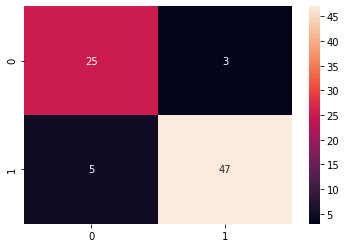

In [10]:
def plot_conf_mat(Y_pred, Y_gt):
    """
    Plots Confusion Matrix
    Args:
        Y_pred: predictions array (np.array)
        Y_gt: ground truth array (np.array)
    """
    conf_mat = pd.DataFrame(confusion_matrix(Y_gt, Y_pred, labels=[1,0]))
    sn.heatmap(conf_mat, annot=True)
    
plot_conf_mat(Y_pred, Y_test)

### Observations

After training our Logistic Regression Classifier, we observe a very high Accuracy and F1 Score, which is awesome! Lets keep track of our progress:

| Model | Observations | Accuracy | F1 | 
|:- |:- |:- | :- |
| Logistic Regression | High accuracy, very few false positives and false negatives | 88% | 88% |

In [11]:
# save state dictionary of weights and bias
if __name__ == "__main__":
    torch.save(model.state_dict(), "suv_predictor.pt")